# INTRO

## road to pipeline
* Import neccessary libraries
    * define useful functions - (no missing values)
    * read in data
<br><br>
* filter sector-wise data
* preprocess the filtered data
    * plot sector-wise visualization
    * check for missing data
    * clean outliers
    * sector-wise groupings by volume (low/mid/high)
<br><br>
* modelling
    * hyperparameters/tunings
    * cross validation
    * feature engineering
    * prediction backtesting
<br><br>
* forecasting
    * time series pipeline

# IMPORT LIBRARIES & READ DATA

## google drive mount to colab

In [1]:
# # connect to gdrive first
# from google.colab import drive
# drive.mount('/content/gdrive')

## importing

In [2]:
import numpy as np
import pandas as pd
import math
import random
import itertools
import time

# visualization
import seaborn as sns
sns.set_style('darkgrid')

# date libraries
import datetime
import holidays
from datetime import date

# matplotlib libraries
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter
import matplotlib.dates as mdates

# scipy library
from scipy import stats
from scipy.stats import norm

# sklearn library
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# prophet library
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric
from prophet.diagnostics import performance_metrics, cross_validation


/home/lordmax/.virtualenvs/jupyterworld/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## defining useful functions

In [3]:
# missing data
def missing_data(input_data):
    '''
    This function returns dataframe with information about the percentage of nulls in each column and the column data type.
    
    input: pandas df
    output: pandas df
    
    '''
    
    total = input_data.isnull().sum()
    percent = (input_data.isnull().sum()/input_data.isnull().count()*100)
    table = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
    types = []
    for col in input_data.columns: 
        dtype = str(input_data[col].dtype)
        types.append(dtype)
    table["Types"] = types
    return(pd.DataFrame(table))

# mean absolute percentage error function
def mape(actual, pred):
    '''
    Mean Absolute Percentage Error (MAPE) Function

    input: list/series for actual values and predicted values
    output: mape value
    '''

    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

## read data

In [4]:
datapath = 'relevant_stock_market_data2.csv'
# datapath = '/content/gdrive/MyDrive/Molten Trust Limited/stock market time series data/relevant_stock_market_data2.csv'

In [5]:
tsdata = pd.read_csv(datapath, parse_dates=['DATE'], index_col='DATE')

In [6]:
min(tsdata.index), max(tsdata.index)

(Timestamp('2003-01-02 00:00:00'), Timestamp('2023-02-28 00:00:00'))

In [7]:
tsdata['SECTOR'].unique()

array(['SERVICES', 'FINANCIAL SERVICES', 'NATURAL RESOURCES',
       'CONSTRUCTION/REAL ESTATE', 'OIL AND GAS', 'INDUSTRIAL GOODS',
       'CONSUMER GOODS', 'CONGLOMERATES', 'HEALTHCARE', 'AGRICULTURE',
       'ICT', 'UTILITIES'], dtype=object)

# FILTER/RESTRUCTURE

In [8]:
# filtering for agriculture stocks
filtered_stock_data = tsdata[tsdata['SECTOR'] == 'FINANCIAL SERVICES']

In [9]:
del filtered_stock_data['SECTOR']

In [11]:
filtered_stock_data.head()

,SYMBOL,CLOSEPRICE
DATE,,
2003-01-02,ACCESSCORP,1.82
2003-01-03,ACCESSCORP,1.83
2003-01-06,ACCESSCORP,1.90
2003-01-07,ACCESSCORP,1.90
2003-01-08,ACCESSCORP,1.98


In [18]:
filtered_stock_data.SYMBOL.unique()


array(['ACCESSCORP', 'AIICO', 'CORNERST', 'FBNH', 'GTCO', 'GUINEAINS',
       'LASACO', 'LINKASSURE', 'MBENEFIT', 'NEM', 'NESF', 'NIGERINS',
       'PRESTIGE', 'ROYALEX', 'STDINSURE', 'STERLNBANK', 'SUNUASSUR',
       'UBA', 'UBN', 'WAPIC', 'WEMABANK', 'FCMB', 'ZENITHBANK',
       'FIDELITYBK', 'STANBIC', 'UNITYBNK', 'ETI', 'SOVRENINS', 'UNHOMES',
       'DEAPCAP', 'INTENEGINS', 'STACO', 'ABBEYBDS', 'ASOSAVINGS',
       'CHIPLC', 'GOLDINSURE', 'REGALINS', 'UNIVINSURE', 'AFRINSURE',
       'MANSARD', 'RESORTSAL', 'VERITASKAP', 'NPFMCRFBK', 'AFRIPRUD',
       'INFINITY', 'UCAP', 'LIVINGTRUST', 'JAIZBANK', 'NGXGROUP'],
      dtype=object)

In [13]:
# pivoting the Dataframe to the number of unique symbols
pivoted_tsdata = filtered_stock_data.pivot(columns='SYMBOL', values='CLOSEPRICE')
final_tsdata = pivoted_tsdata.rename(columns={'ACCESSCORP': 'ACCESSCORP', 'AIICO': 'AIICO', 
        'CORNERST': 'CORNERST', 'FBNH': 'FBNH', 'GTCO': 'GTCO', 'GUINEAINS': 'GUINEAINS', 
        'LASACO': 'LASACO', 'LINKASSURE': 'LINKASSURE', 'MBENEFIT': 'MBENEFIT', 'NEM': 'NEM', 
        'NESF': 'NESF', 'NIGERINS': 'NIGERINS', 'PRESTIGE': 'PRESTIGE', 'ROYALEX': 'ROYALEX', 
        'STDINSURE': 'STDINSURE', 'STERLNBANK': 'STERLNBANK', 'SUNUASSUR': 'SUNUASSUR', 
        'UBA': 'UBA', 'UBN': 'UBN', 'WAPIC': 'WAPIC', 'WEMABANK': 'WEMABANK', 'FCMB': 'FCMB', 
        'ZENITHBANK': 'ZENITHBANK', 'FIDELITYBK': 'FIDELITYBK', 'STANBIC': 'STANBIC', 
        'UNITYBNK': 'UNITYBNK', 'ETI': 'ETI', 'SOVRENINS': 'SOVRENINS', 'UNHOMES': 'UNHOMES', 
        'DEAPCAP': 'DEAPCAP', 'INTENEGINS': 'INTENEGINS', 'STACO': 'STACO', 'ABBEYBDS': 'ABBEYBDS', 
        'ASOSAVINGS': 'ASOSAVINGS', 'CHIPLC': 'CHIPLC', 'GOLDINSURE': 'GOLDINSURE', 
        'REGALINS': 'REGALINS', 'UNIVINSURE': 'UNIVINSURE', 'AFRINSURE': 'AFRINSURE', 'MANSARD': 'MANSARD', 
        'RESORTSAL': 'RESORTSAL', 'VERITASKAP': 'VERITASKAP', 'NPFMCRFBK': 'NPFMCRFBK', 'AFRIPRUD': 'AFRIPRUD', 
        'INFINITY': 'INFINITY', 'UCAP': 'UCAP', 'LIVINGTRUST': 'LIVINGTRUST', 'JAIZBANK': 'JAIZBANK', 'NGXGROUP': 'NGXGROUP'})


In [14]:
# Resample the data with daily frequency by interpolation
financial_tsdata = final_tsdata.resample('D').interpolate(method='linear')

In [15]:
financial_tsdata.fillna(0, inplace=True)

# PREPROCESSING

## visualization

In [16]:
financial_tsdata.head()

SYMBOL,ABBEYBDS,ACCESSCORP,AFRINSURE,AFRIPRUD,AIICO,ASOSAVINGS,CHIPLC,CORNERST,DEAPCAP,ETI,...,UBA,UBN,UCAP,UNHOMES,UNITYBNK,UNIVINSURE,VERITASKAP,WAPIC,WEMABANK,ZENITHBANK
DATE,,,,,,,,,,,,,,,,,,,,,
2003-01-02,0.0,1.820000,0.0,0.0,1.370000,0.0,0.0,1.37,0.0,0.0,...,5.790000,22.390000,0.0,0.0,0.0,0.0,0.0,1.6,5.76,0.0
2003-01-03,0.0,1.830000,0.0,0.0,1.430000,0.0,0.0,1.43,0.0,0.0,...,5.830000,22.300000,0.0,0.0,0.0,0.0,0.0,1.6,5.76,0.0
2003-01-04,0.0,1.853333,0.0,0.0,1.453333,0.0,0.0,1.41,0.0,0.0,...,5.833333,22.533333,0.0,0.0,0.0,0.0,0.0,1.6,5.76,0.0
2003-01-05,0.0,1.876667,0.0,0.0,1.476667,0.0,0.0,1.39,0.0,0.0,...,5.836667,22.766667,0.0,0.0,0.0,0.0,0.0,1.6,5.76,0.0
2003-01-06,0.0,1.900000,0.0,0.0,1.500000,0.0,0.0,1.37,0.0,0.0,...,5.840000,23.000000,0.0,0.0,0.0,0.0,0.0,1.6,5.76,0.0


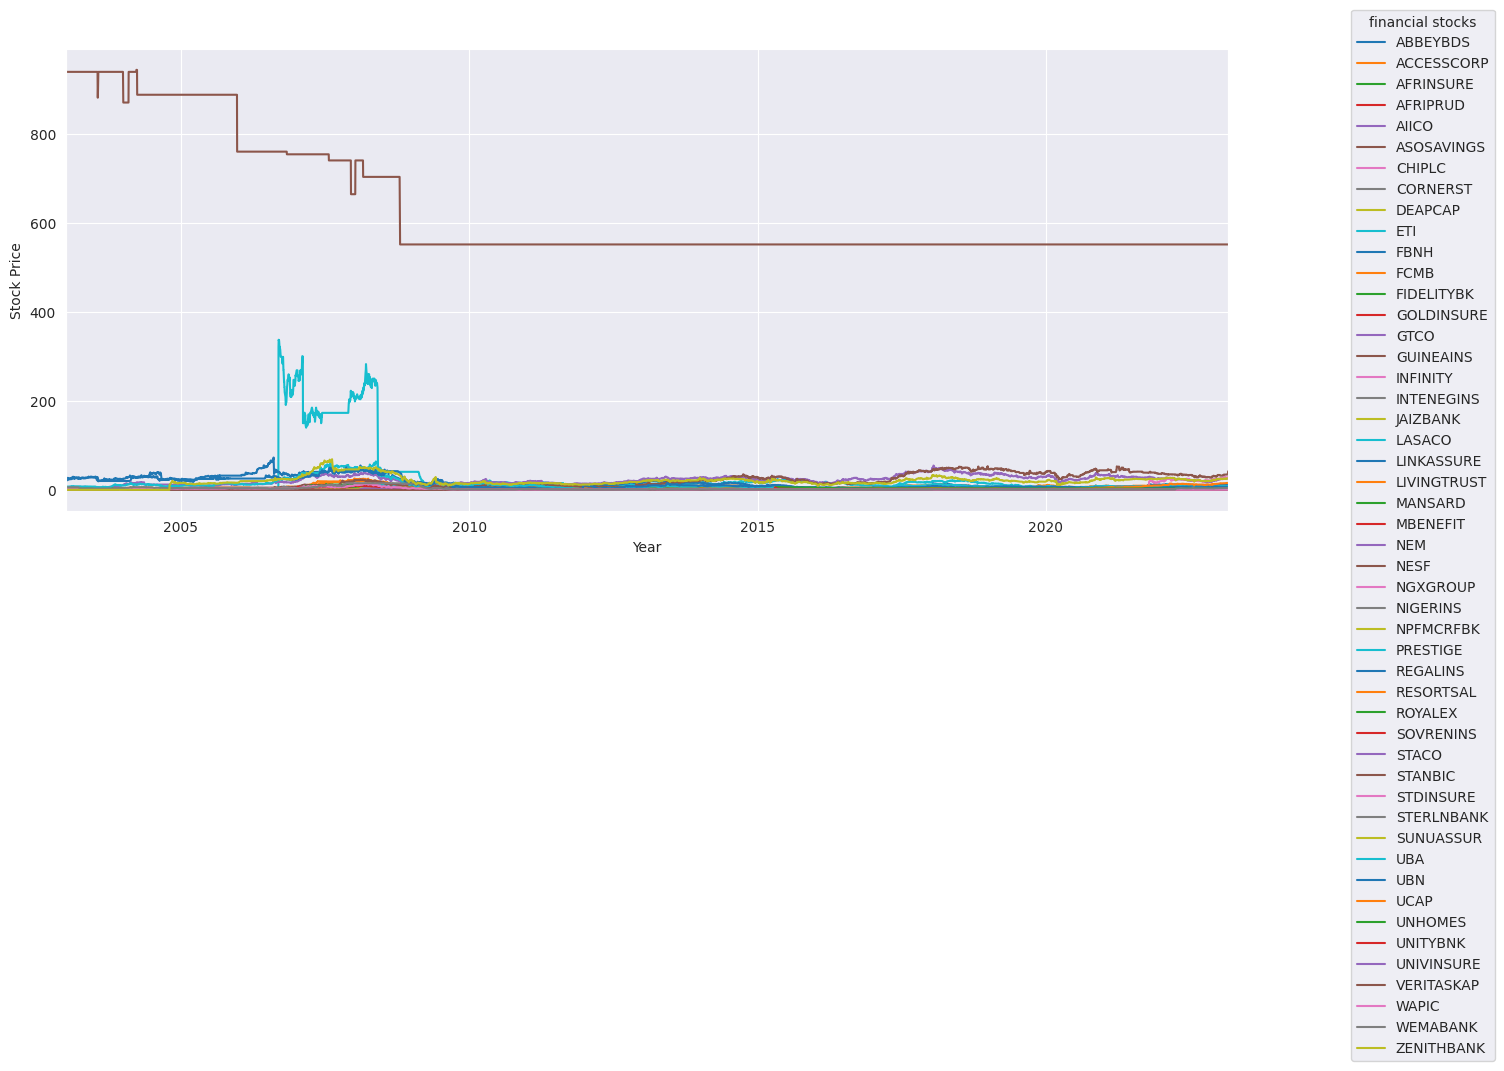

In [24]:
# Plotting
financial_tsdata.plot(figsize=(15, 6))
plt.xlabel('Year')
plt.ylabel('Stock Price')
plt.grid(True)
plt.legend(title='financial stocks', loc='best', bbox_to_anchor=(1.1, 1.1))
plt.show()

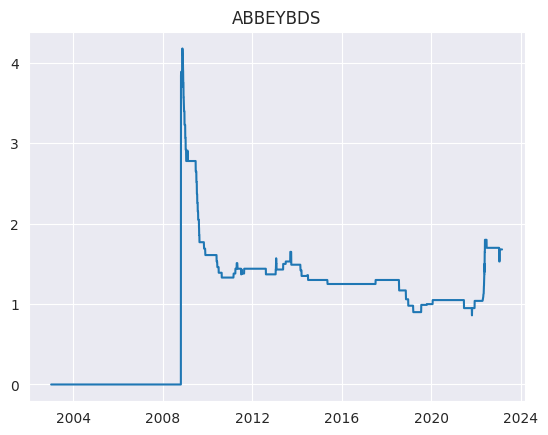

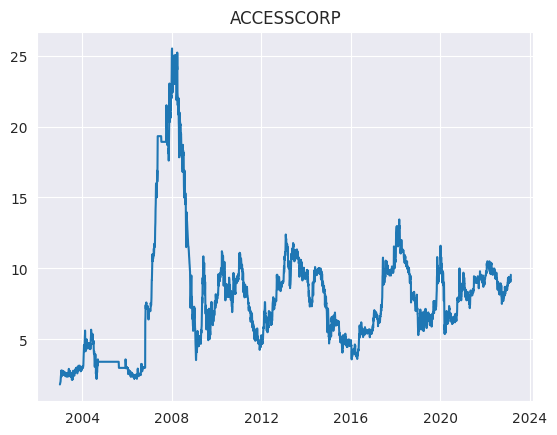

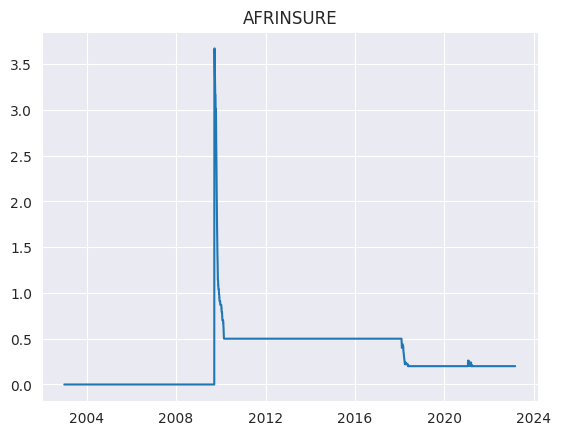

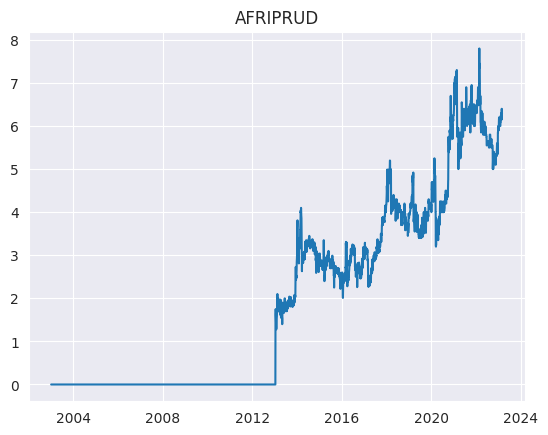

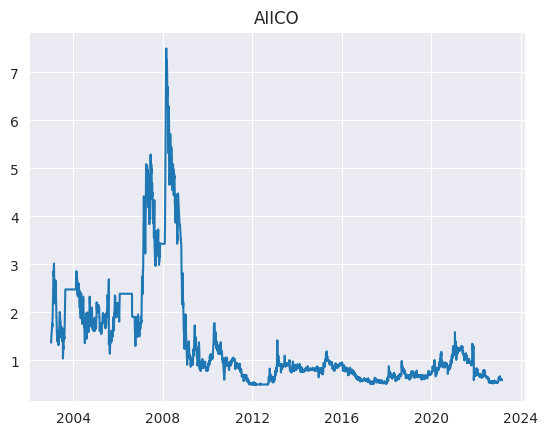

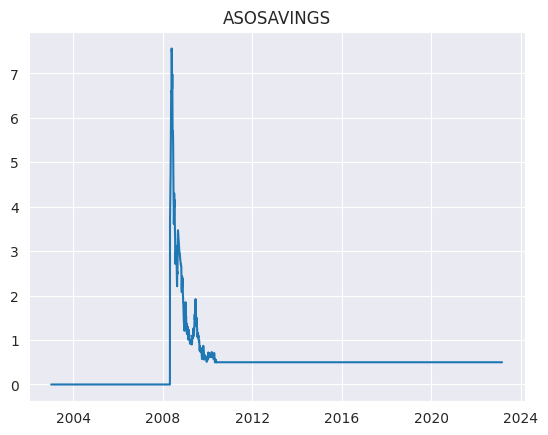

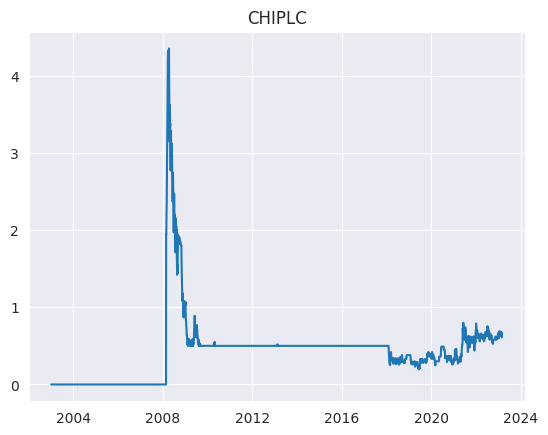

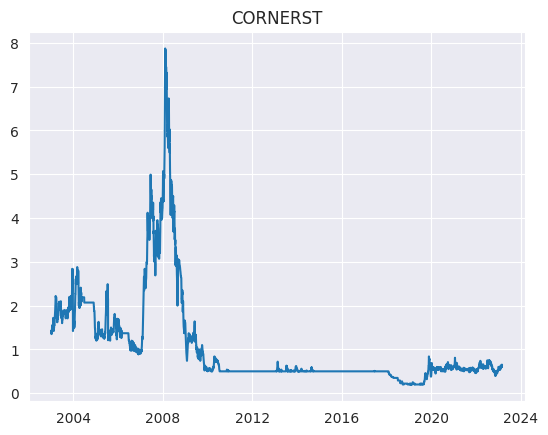

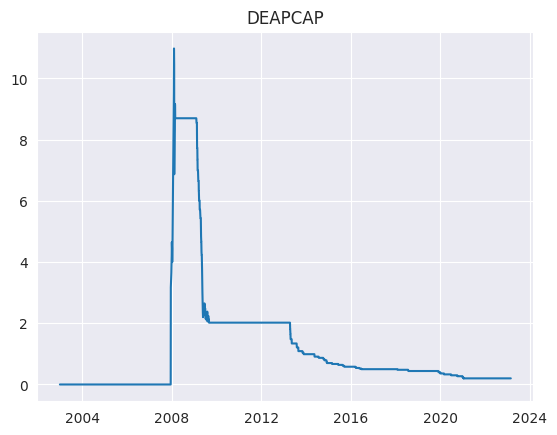

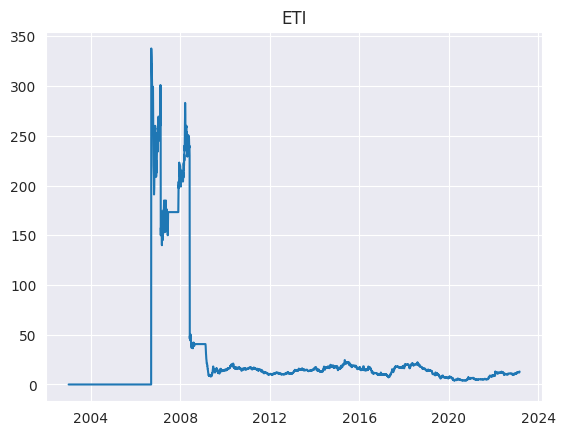

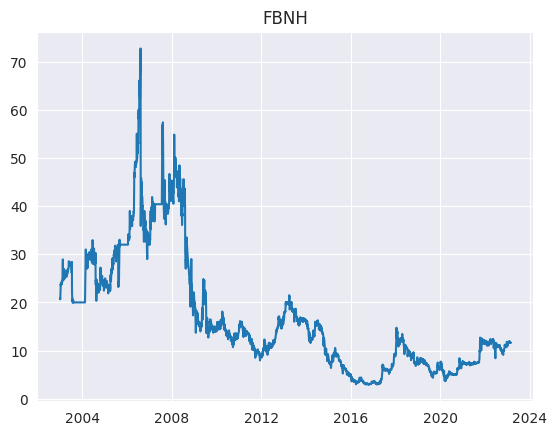

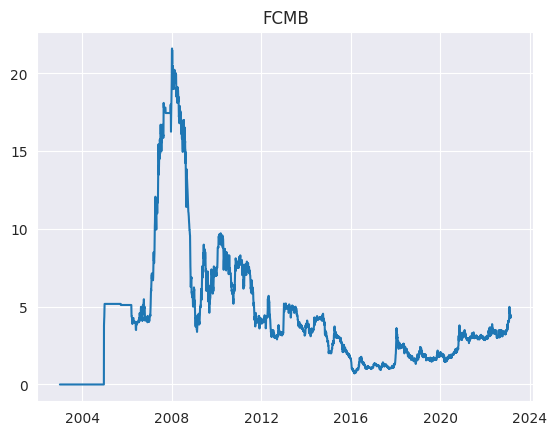

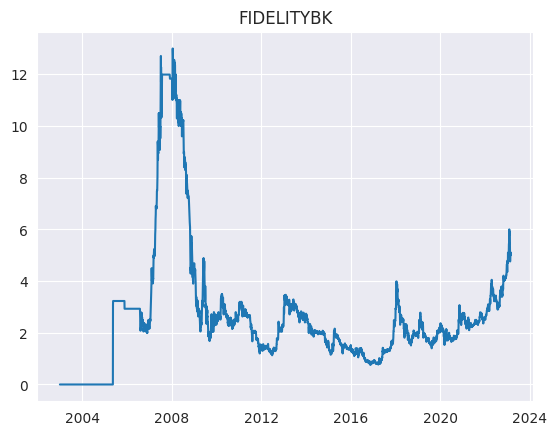

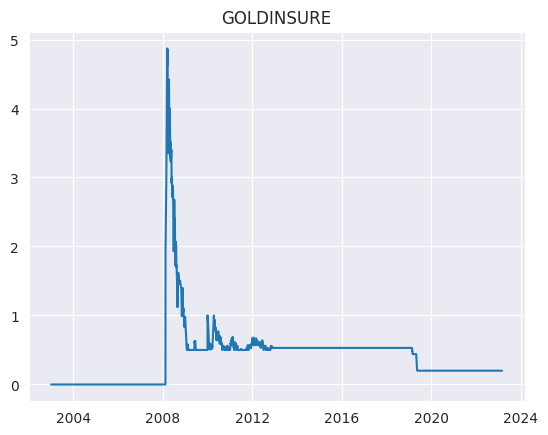

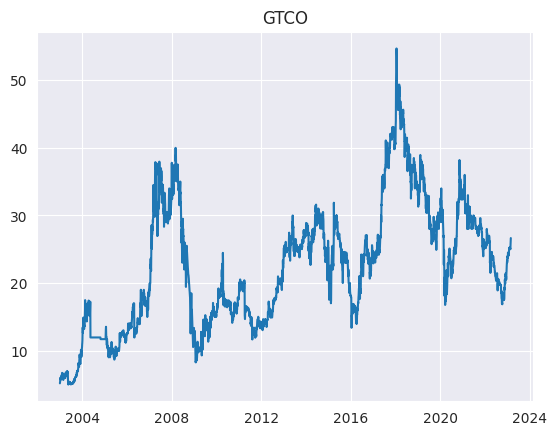

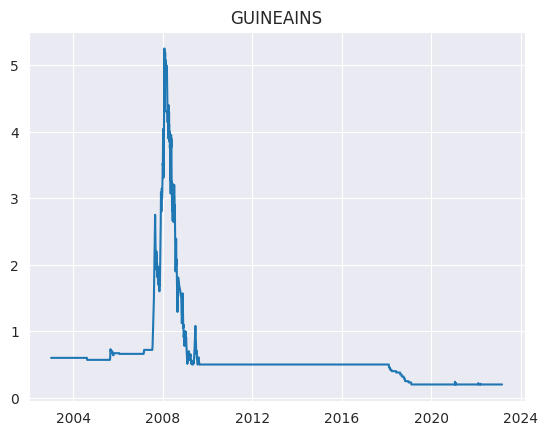

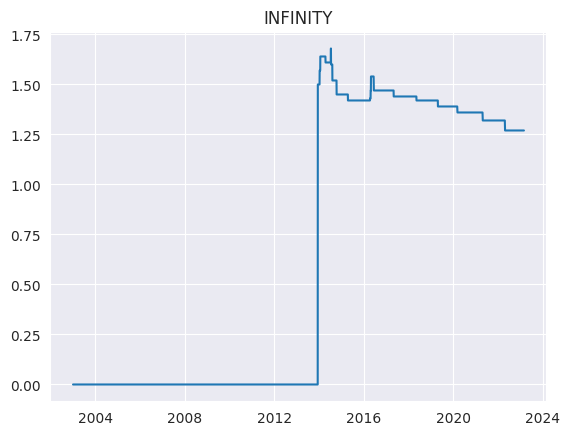

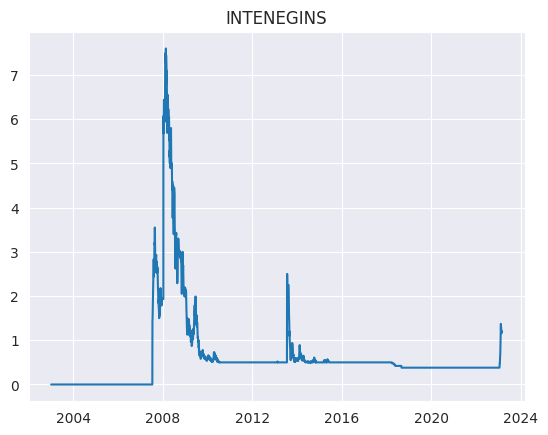

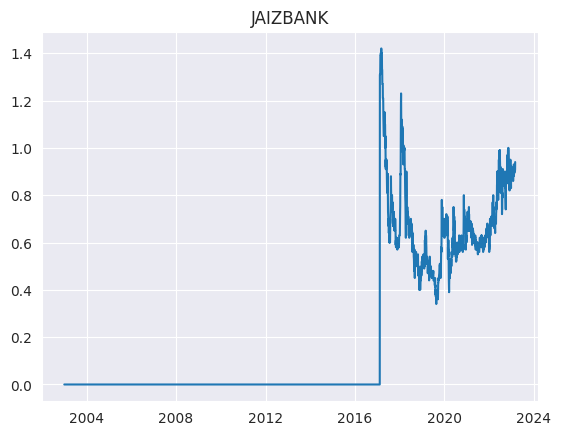

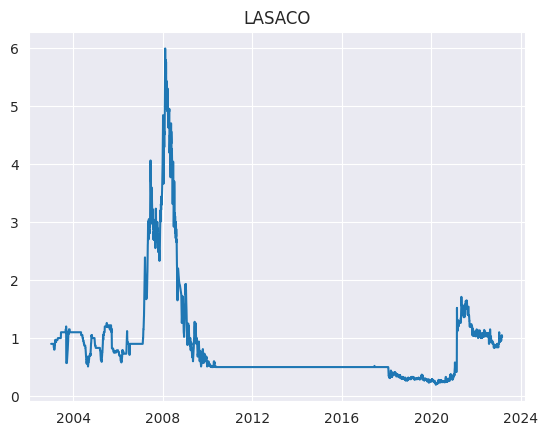

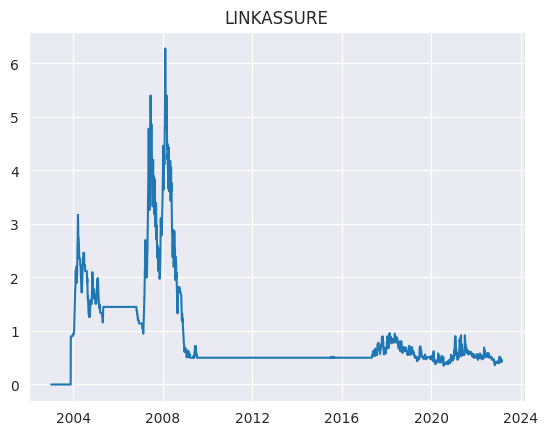

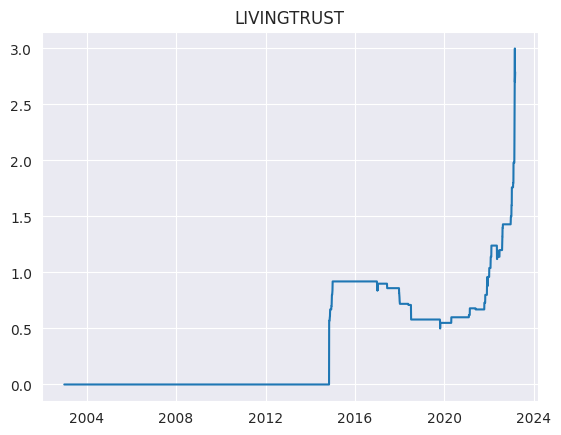

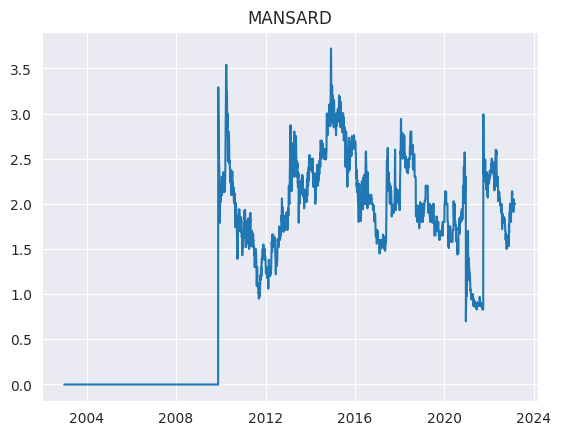

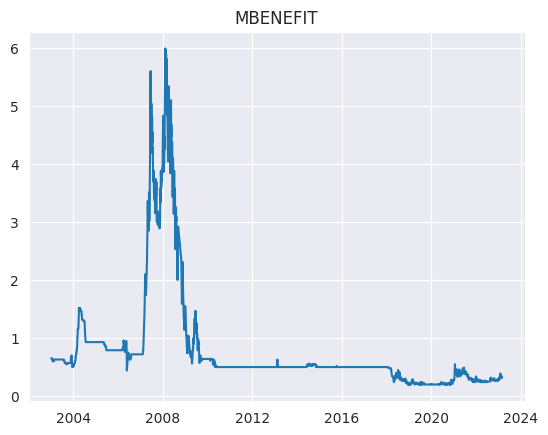

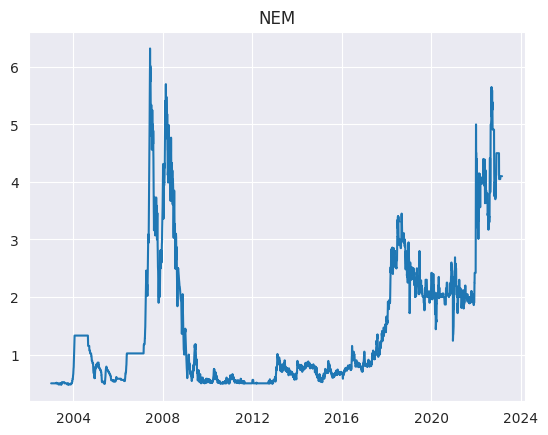

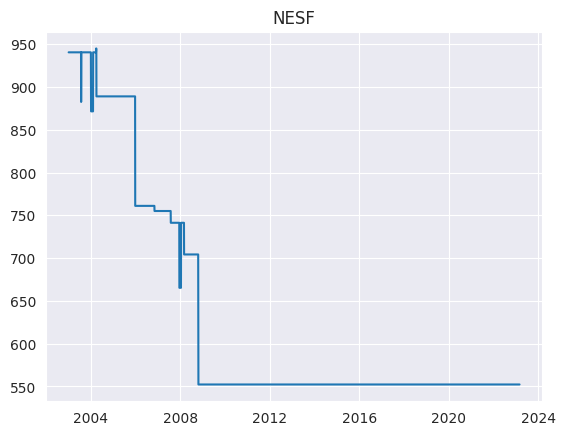

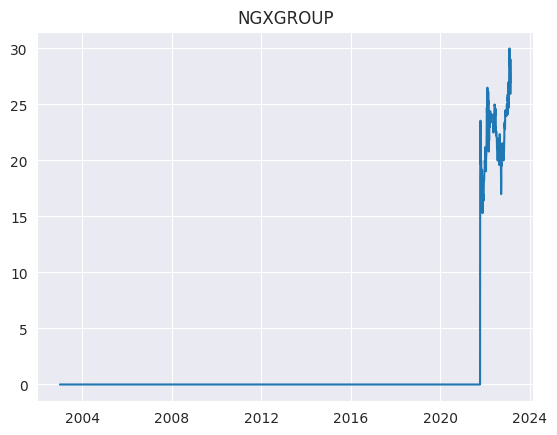

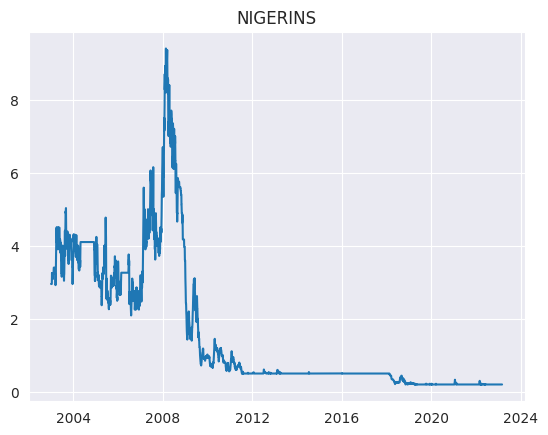

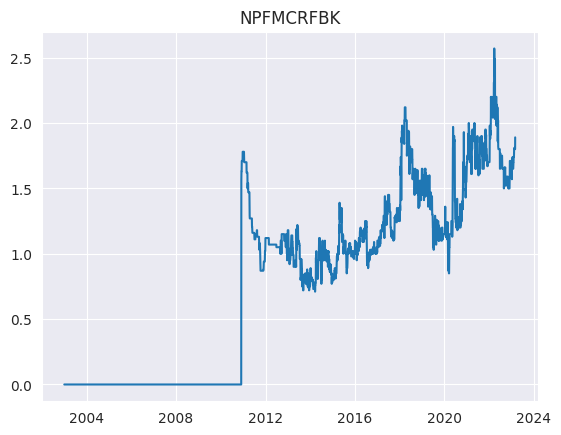

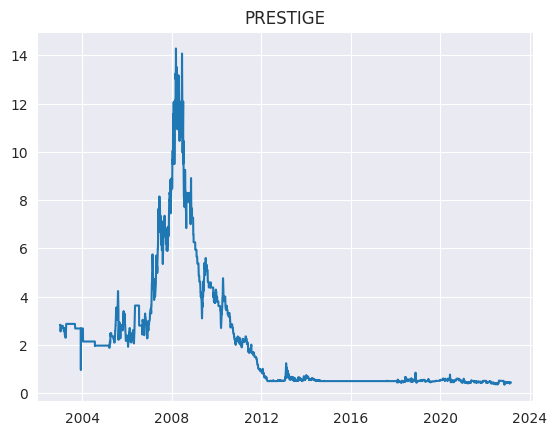

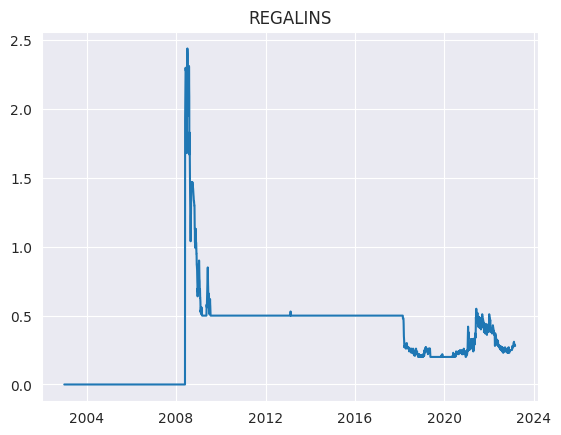

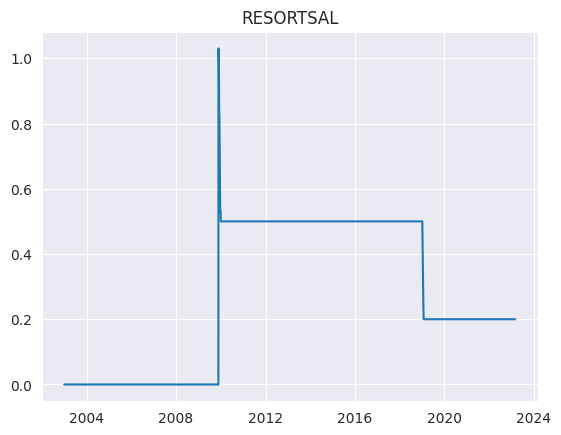

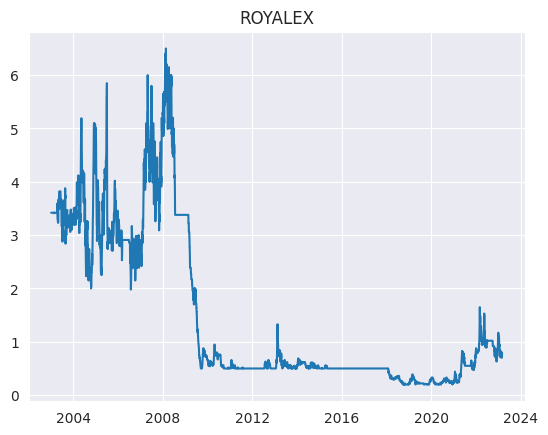

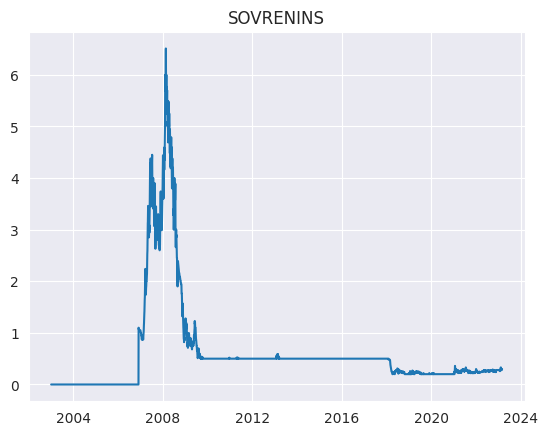

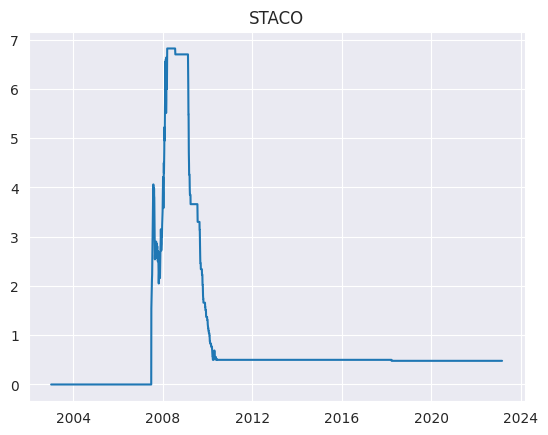

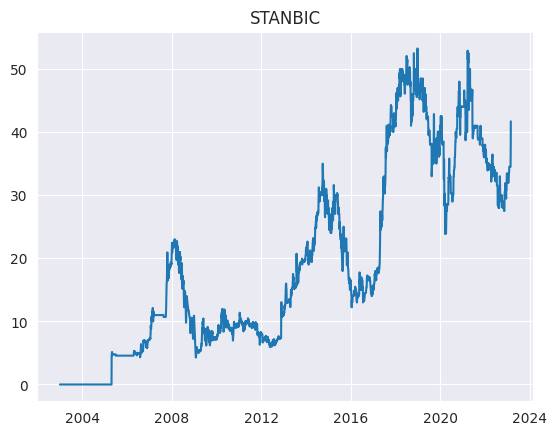

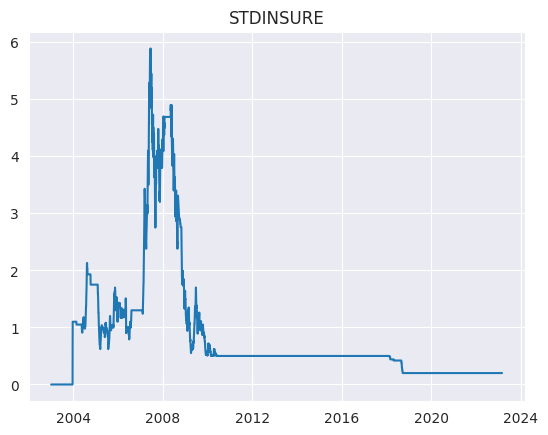

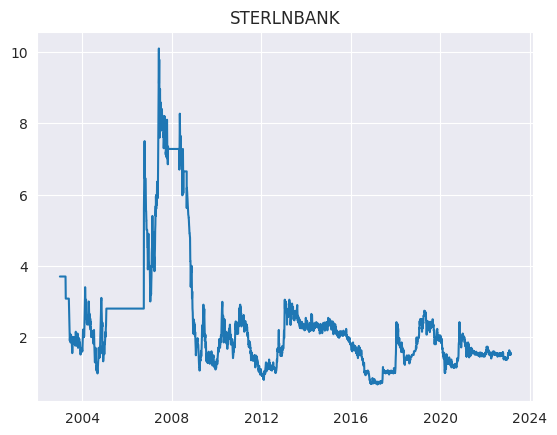

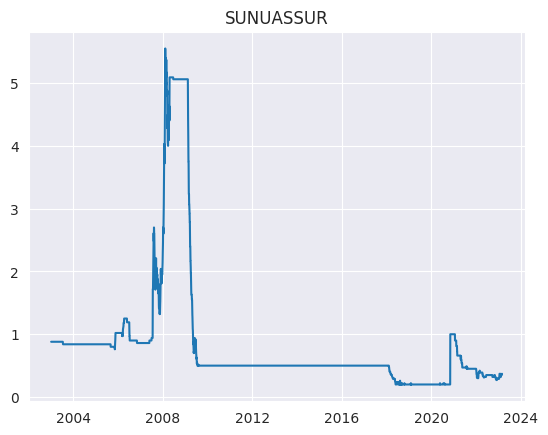

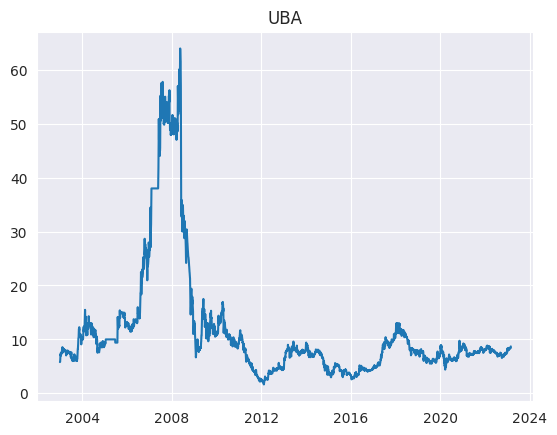

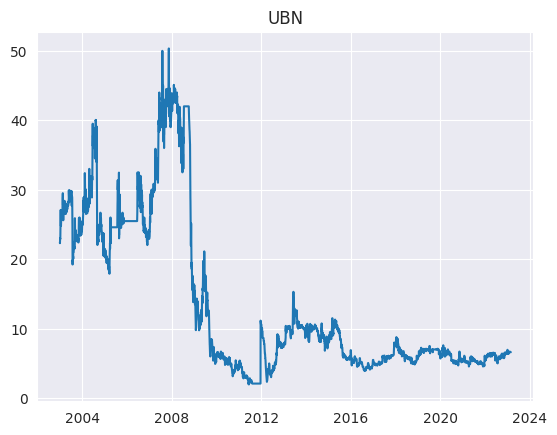

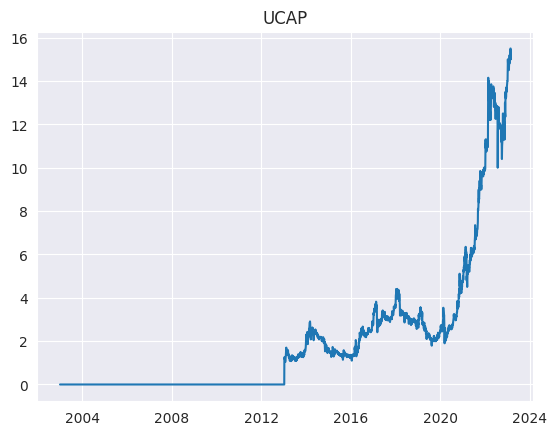

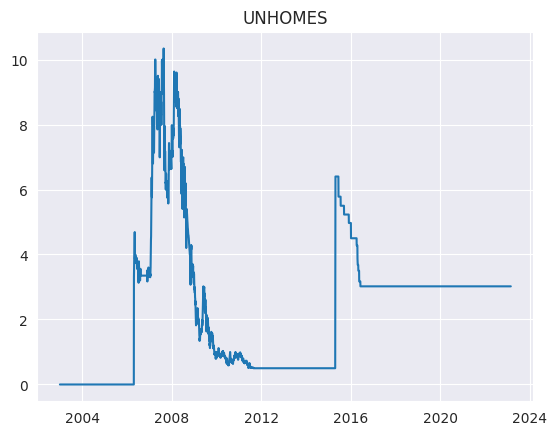

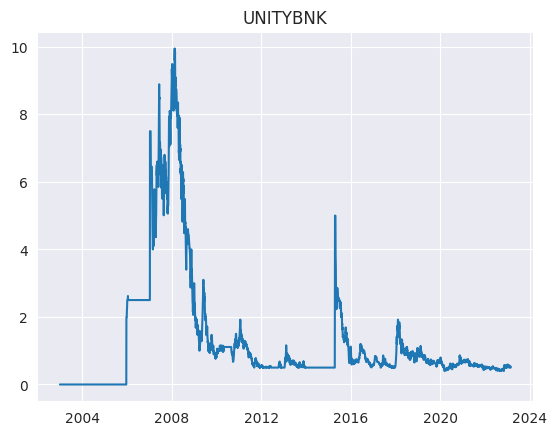

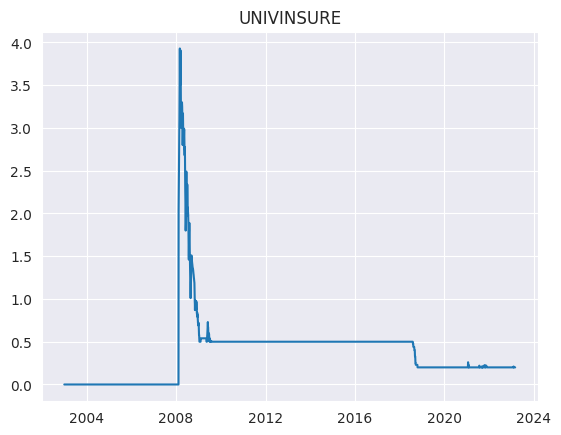

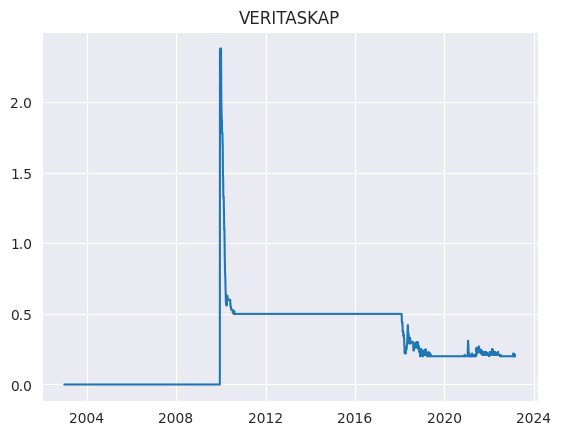

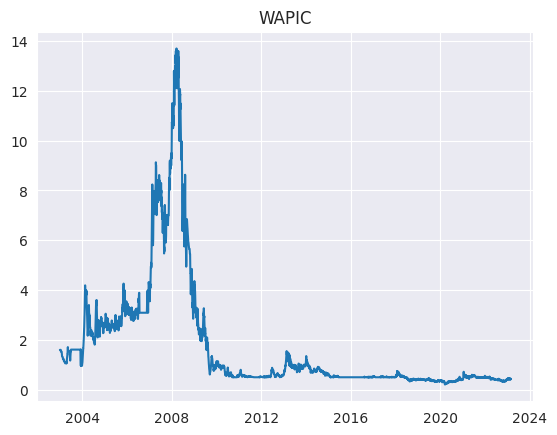

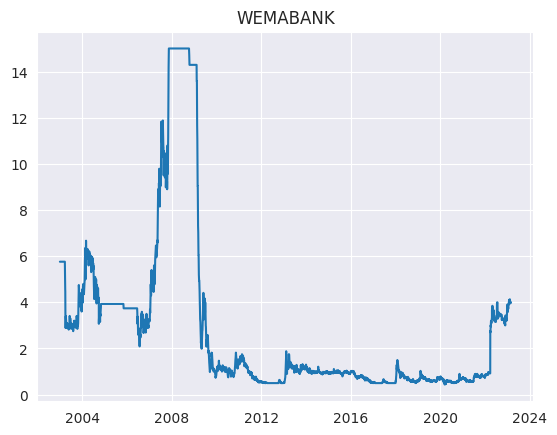

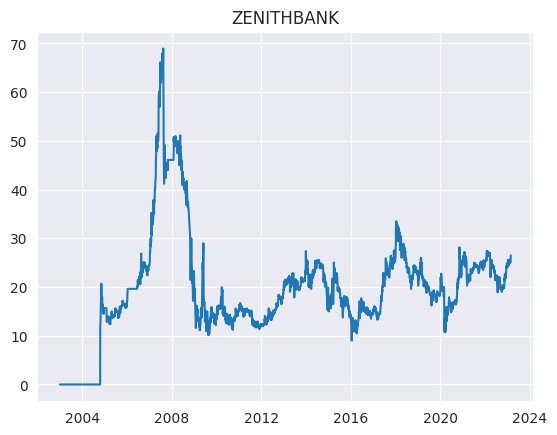

In [25]:
for column in financial_tsdata.columns:
    plt.plot(financial_tsdata[column])
    plt.title(column)
    plt.show()

## cleaning

In [26]:
missing_data(financial_tsdata)

,Total,Percent,Types
SYMBOL,,,
ABBEYBDS,0,0.0,float64
ACCESSCORP,0,0.0,float64
AFRINSURE,0,0.0,float64
AFRIPRUD,0,0.0,float64
AIICO,0,0.0,float64
ASOSAVINGS,0,0.0,float64
CHIPLC,0,0.0,float64
CORNERST,0,0.0,float64
DEAPCAP,0,0.0,float64


## outliers

<b>`Data Cleaning Requirements`</b>
* remove outliers (automated by calculating and removing <b>`z-score`</b>, while Prophet helps impute those values). This will remove the outliers near 0 for all categories.

In [27]:
# getting percentage of rows for each sector that is at 0

(financial_tsdata == 0).astype(int).sum(axis=0)/len(financial_tsdata.sum(axis=0))

SYMBOL
ABBEYBDS        43.244898
ACCESSCORP       0.000000
AFRINSURE       50.000000
AFRIPRUD        74.734694
AIICO            0.000000
ASOSAVINGS      39.591837
CHIPLC          38.306122
CORNERST         0.000000
DEAPCAP         36.938776
ETI             27.510204
FBNH             0.000000
FCMB            14.673469
FIDELITYBK      17.673469
GOLDINSURE      38.102041
GTCO             0.000000
GUINEAINS        0.000000
INFINITY        81.551020
INTENEGINS      33.734694
JAIZBANK       105.142857
LASACO           0.000000
LINKASSURE       6.530612
LIVINGTRUST     88.244898
MANSARD         51.285714
MBENEFIT         0.000000
NEM              0.000000
NESF             0.000000
NGXGROUP       140.020408
NIGERINS         0.000000
NPFMCRFBK       58.979592
PRESTIGE         0.000000
REGALINS        40.244898
RESORTSAL       51.367347
ROYALEX          0.000000
SOVRENINS       29.122449
STACO           33.367347
STANBIC         17.224490
STDINSURE        7.163265
STERLNBANK       0.000000
SUNUA

In [29]:
# breaking out each consumer stocks into it's own dataframe
prediction_df_financial_list = []

# cleaning up dataframe using z-score to remove outliers that heavily bias the model
for column in financial_tsdata.columns:
    df_financial_clean = financial_tsdata[[column]].reset_index()
    
    z = np.abs(stats.zscore(df_financial_clean[column]))
    outlier_index = np.where(z > 4)[0] # As 99.7% of the data points lie between 3 standard deviations (Gaussian Distribution)a
    print("Dropping "+str(len(outlier_index))+" rows for following category: "+column)
    df_financial_clean.drop(index=outlier_index,inplace=True)
    df_financial_clean.set_index('DATE', inplace=True)
    prediction_df_financial_list.append(df_financial_clean)

Dropping 15 rows for following category: ABBEYBDS
Dropping 23 rows for following category: ACCESSCORP
Dropping 49 rows for following category: AFRINSURE
Dropping 0 rows for following category: AFRIPRUD
Dropping 50 rows for following category: AIICO
Dropping 100 rows for following category: ASOSAVINGS
Dropping 113 rows for following category: CHIPLC
Dropping 86 rows for following category: CORNERST
Dropping 7 rows for following category: DEAPCAP


Dropping 86 rows for following category: ETI
Dropping 9 rows for following category: FBNH
Dropping 5 rows for following category: FCMB
Dropping 6 rows for following category: FIDELITYBK
Dropping 124 rows for following category: GOLDINSURE
Dropping 0 rows for following category: GTCO
Dropping 148 rows for following category: GUINEAINS
Dropping 0 rows for following category: INFINITY
Dropping 141 rows for following category: INTENEGINS
Dropping 0 rows for following category: JAIZBANK
Dropping 130 rows for following category: LASACO
Dropping 87 rows for following category: LINKASSURE
Dropping 13 rows for following category: LIVINGTRUST
Dropping 0 rows for following category: MANSARD
Dropping 124 rows for following category: MBENEFIT
Dropping 1 rows for following category: NEM
Dropping 0 rows for following category: NESF
Dropping 129 rows for following category: NGXGROUP
Dropping 18 rows for following category: NIGERINS
Dropping 0 rows for following category: NPFMCRFBK
Dropping 70 rows for

In [30]:
prediction_df_financial_list

[SYMBOL      ABBEYBDS
 DATE                
 2003-01-02      0.00
 2003-01-03      0.00
 2003-01-04      0.00
 2003-01-05      0.00
 2003-01-06      0.00
 ...              ...
 2023-02-24      1.68
 2023-02-25      1.68
 2023-02-26      1.68
 2023-02-27      1.68
 2023-02-28      1.68
 
 [7348 rows x 1 columns],
 SYMBOL      ACCESSCORP
 DATE                  
 2003-01-02    1.820000
 2003-01-03    1.830000
 2003-01-04    1.853333
 2003-01-05    1.876667
 2003-01-06    1.900000
 ...                ...
 2023-02-24    9.200000
 2023-02-25    9.233333
 2023-02-26    9.266667
 2023-02-27    9.300000
 2023-02-28    9.550000
 
 [7340 rows x 1 columns],
 SYMBOL      AFRINSURE
 DATE                 
 2003-01-02        0.0
 2003-01-03        0.0
 2003-01-04        0.0
 2003-01-05        0.0
 2003-01-06        0.0
 ...               ...
 2023-02-24        0.2
 2023-02-25        0.2
 2023-02-26        0.2
 2023-02-27        0.2
 2023-02-28        0.2
 
 [7314 rows x 1 columns],
 SYMBOL      AFRIPR

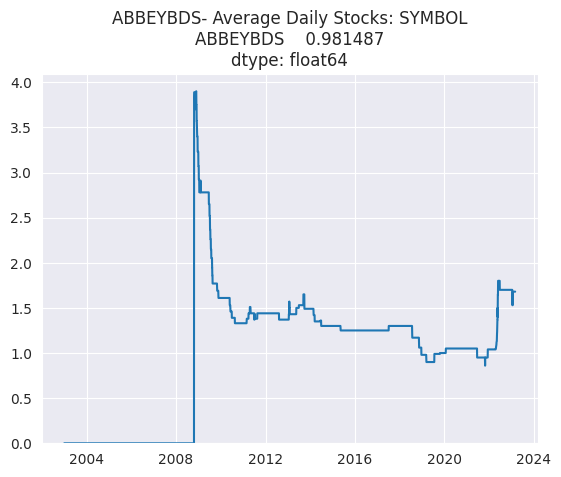

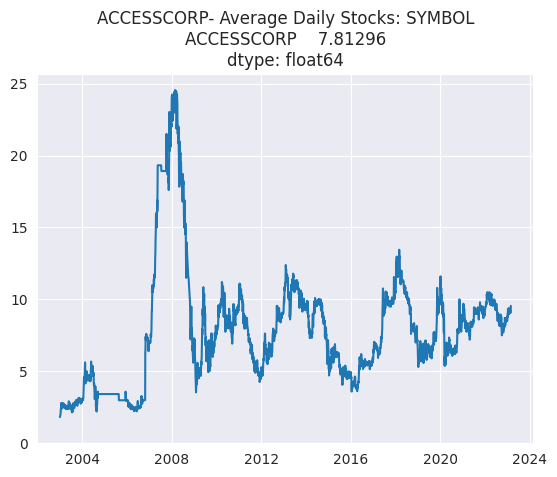

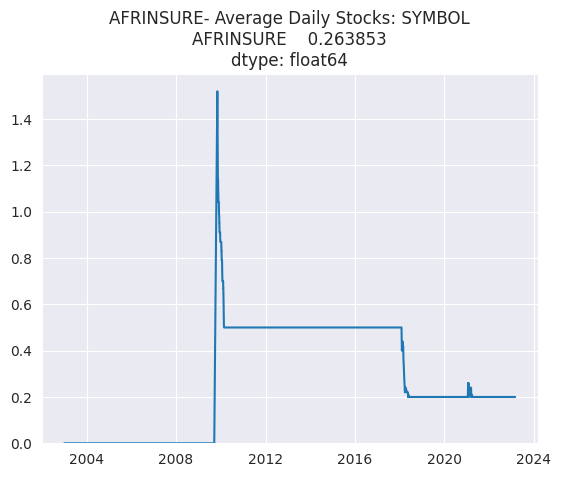

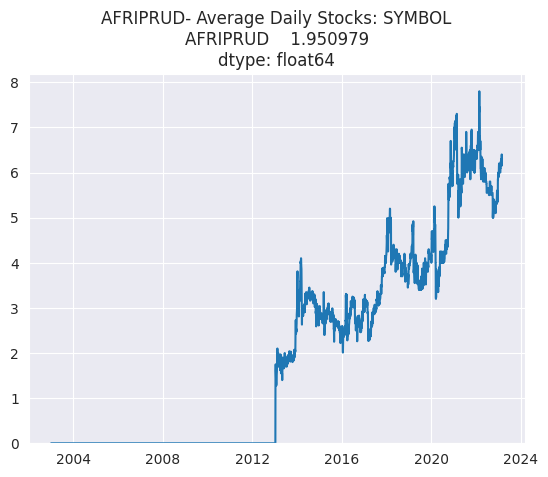

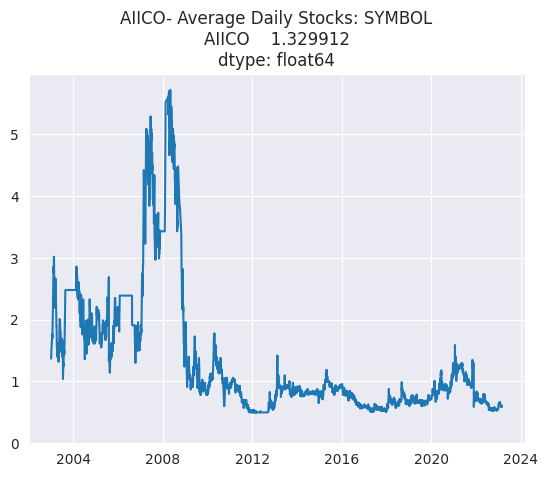

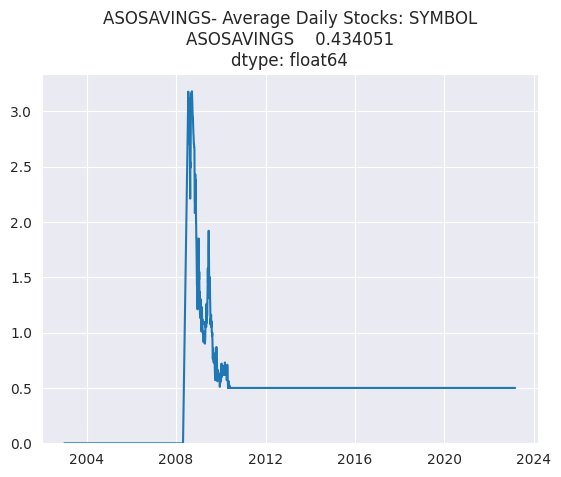

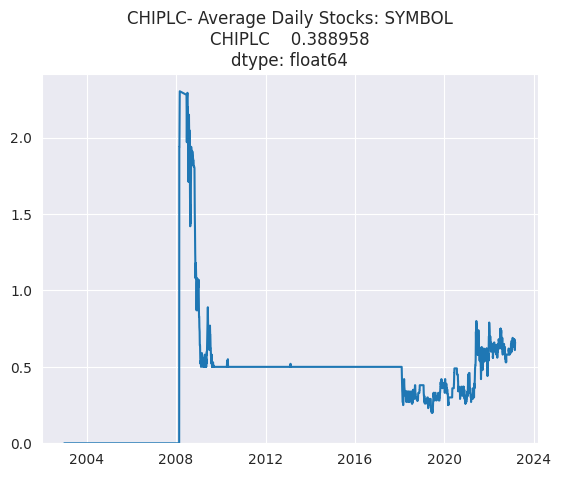

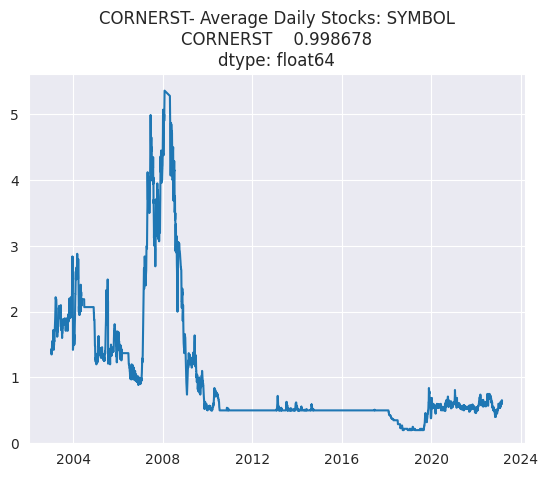

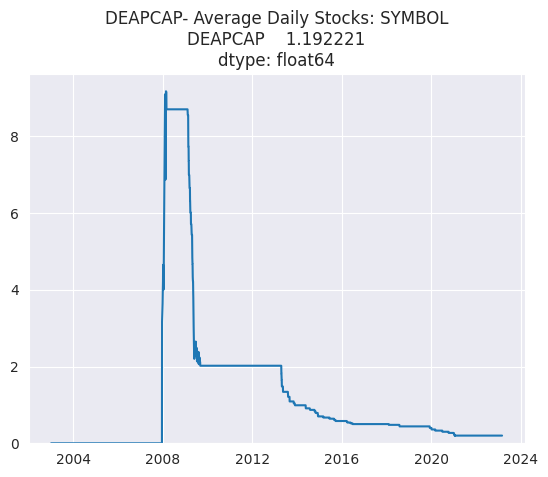

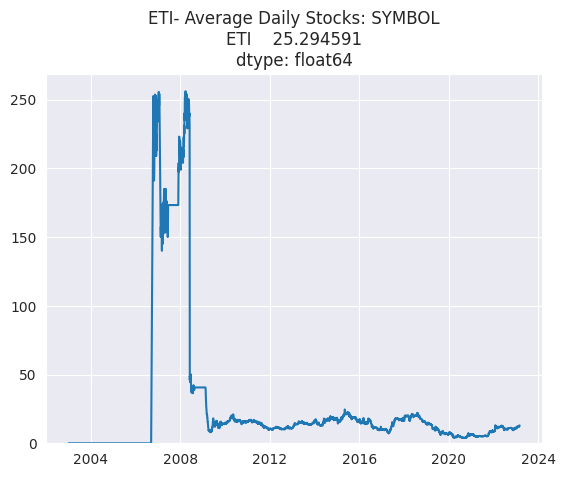

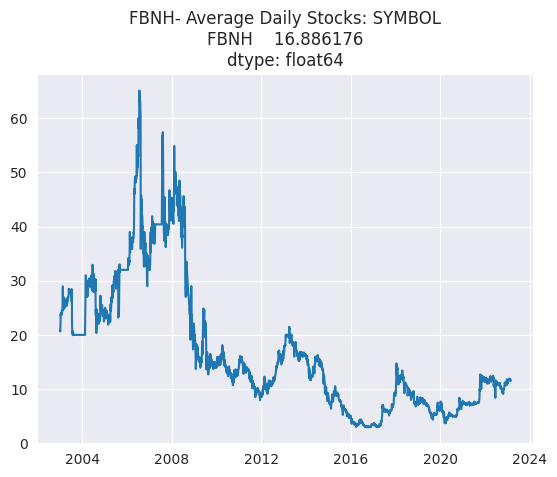

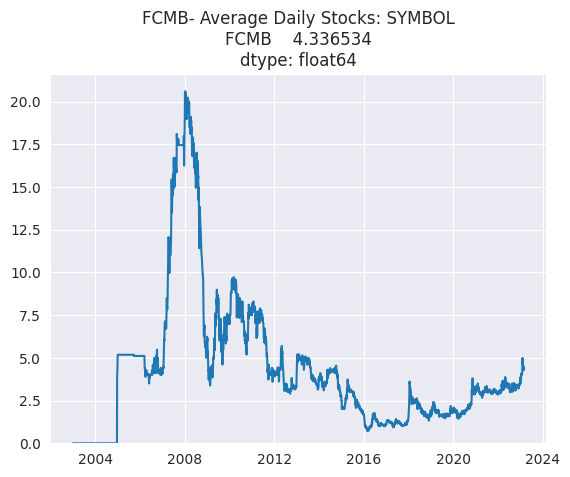

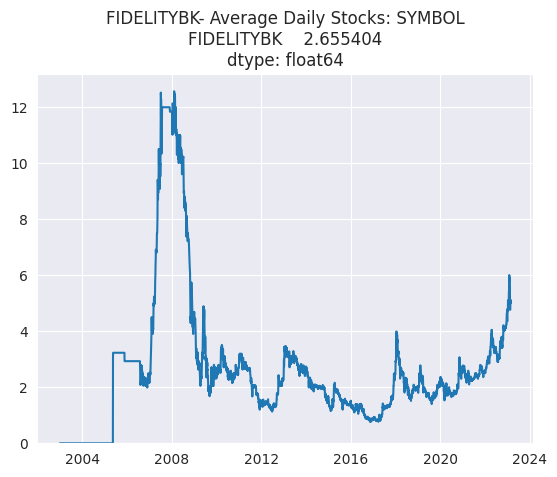

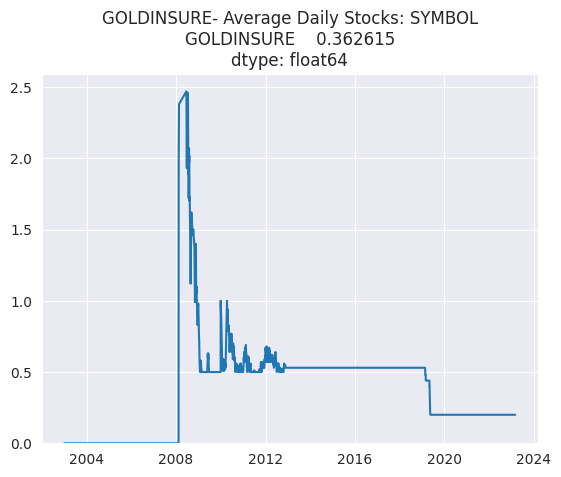

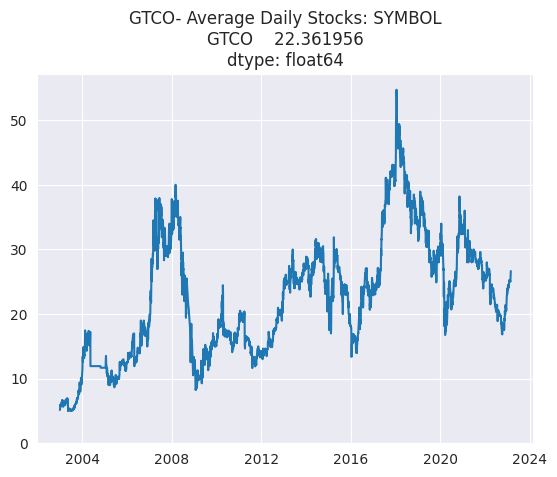

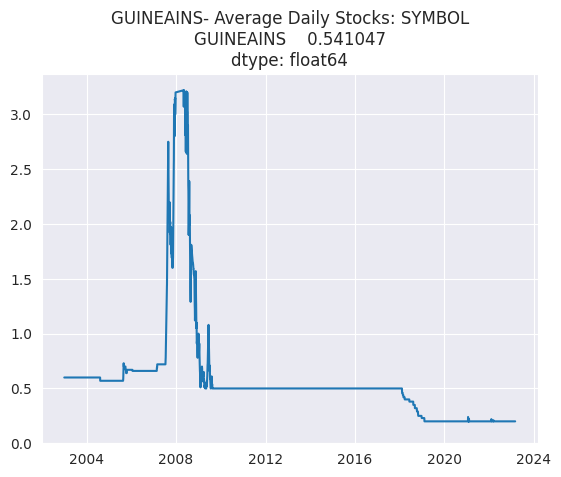

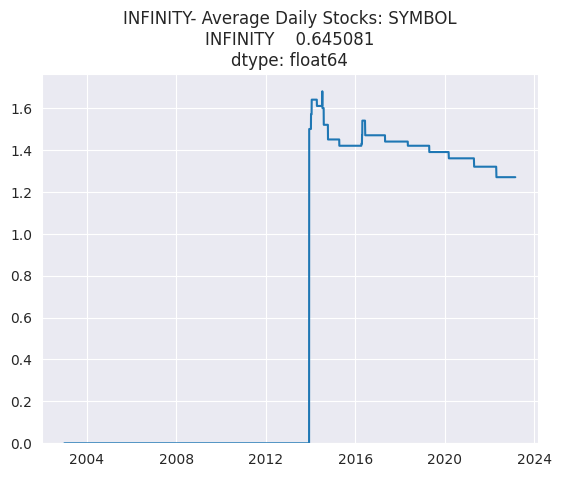

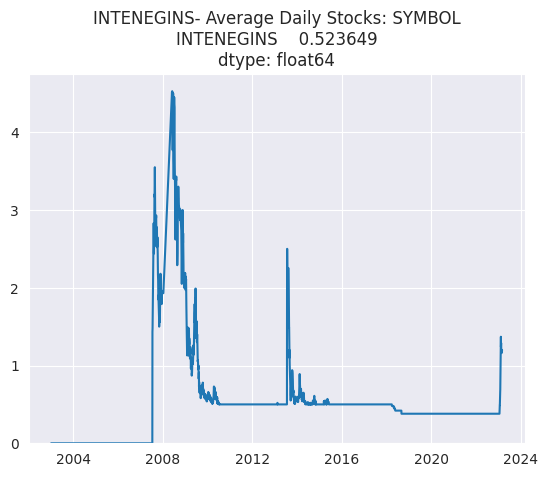

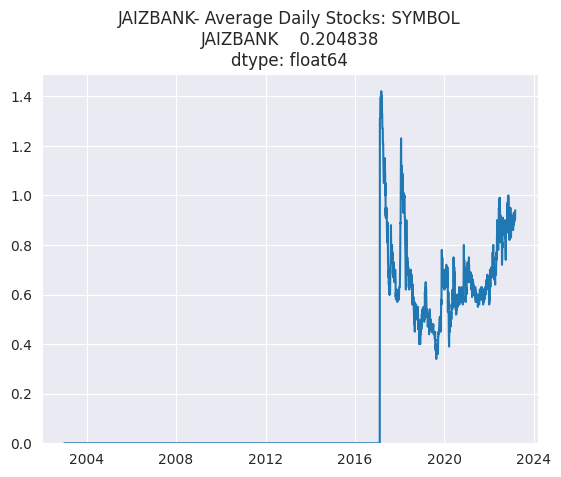

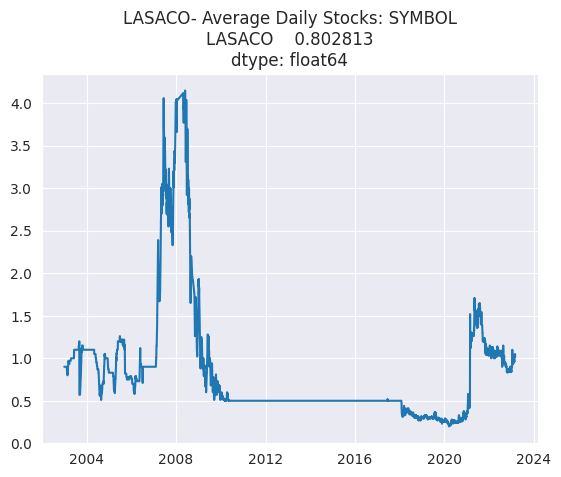

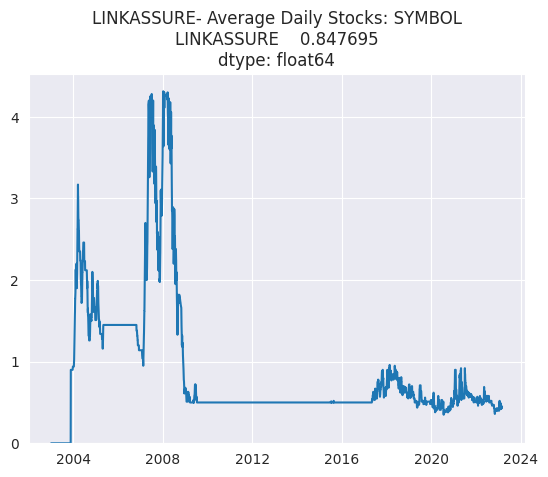

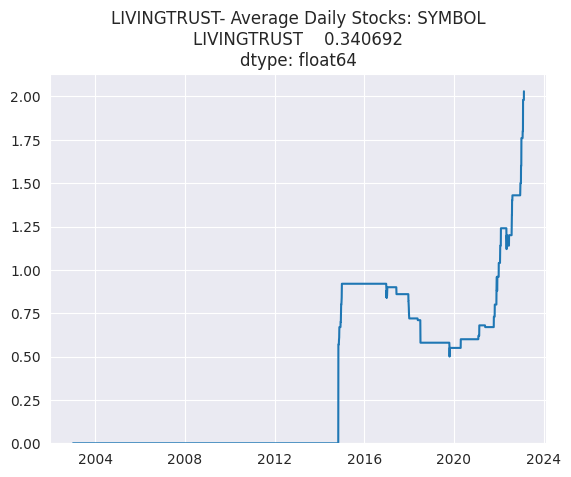

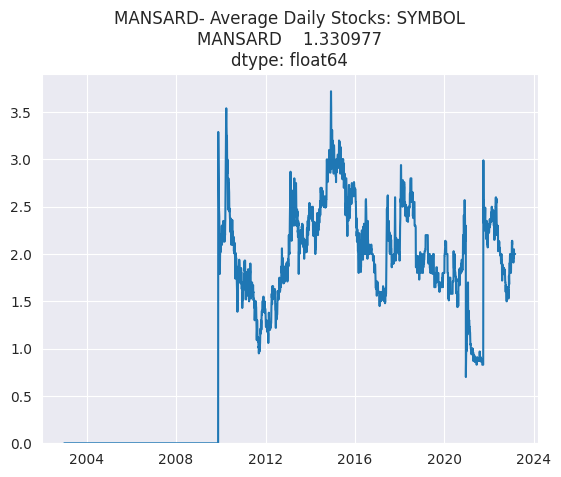

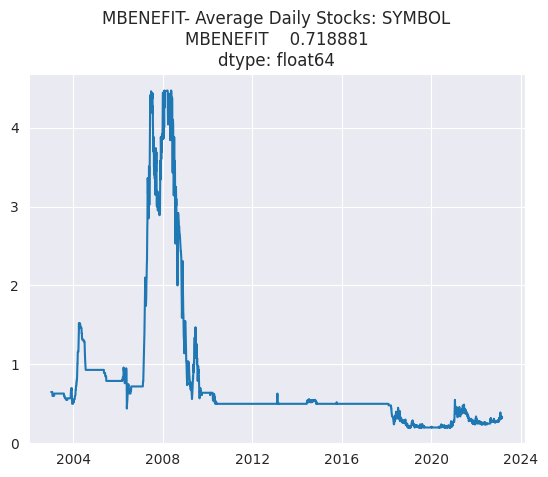

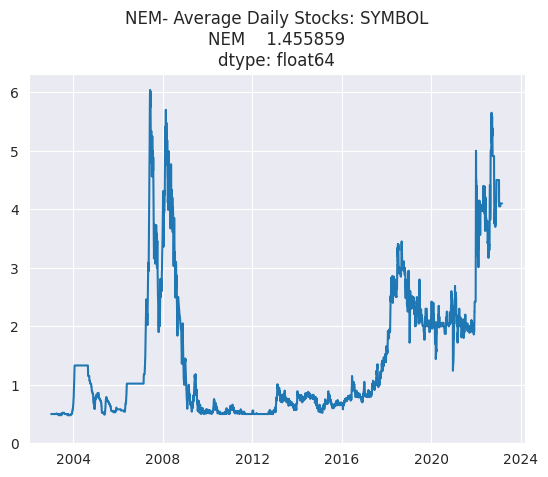

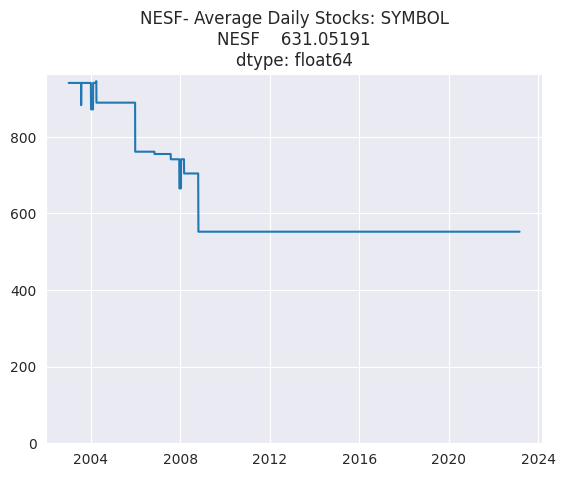

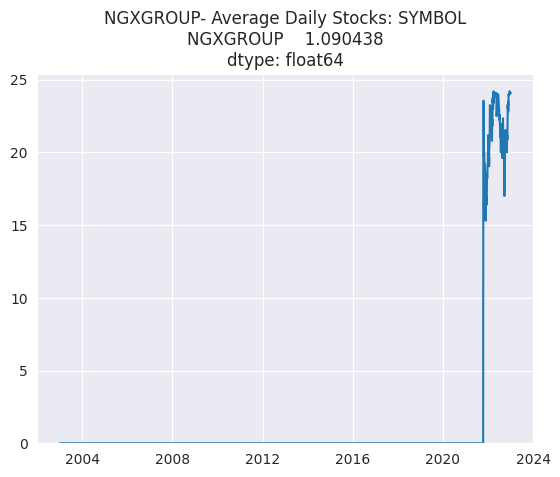

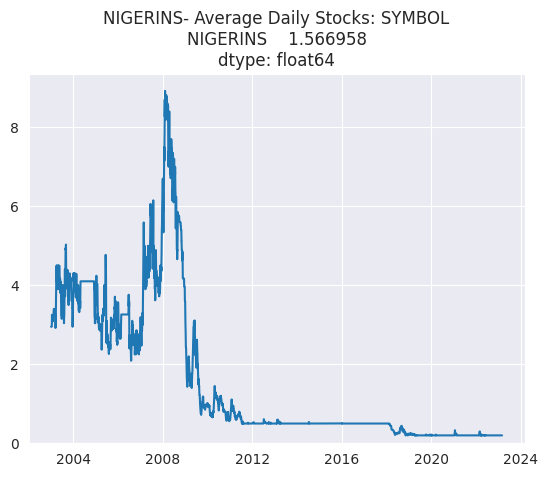

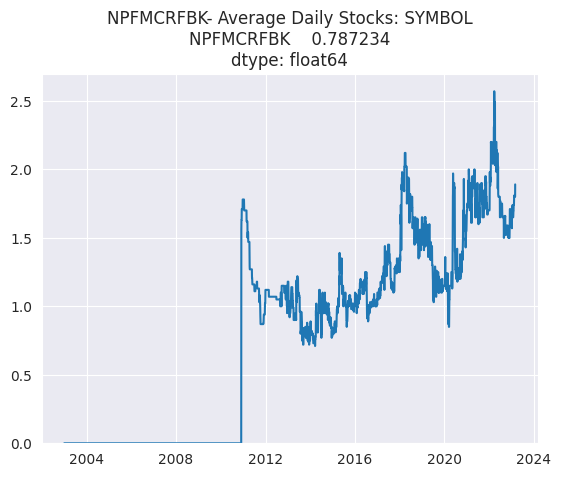

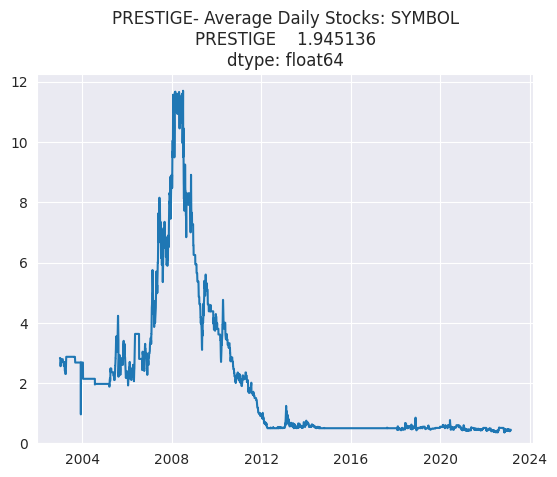

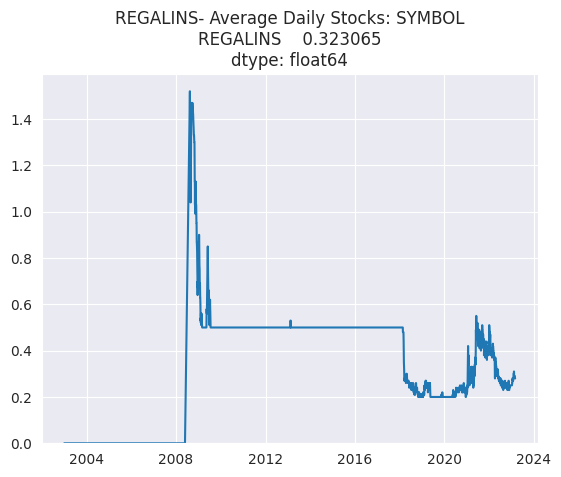

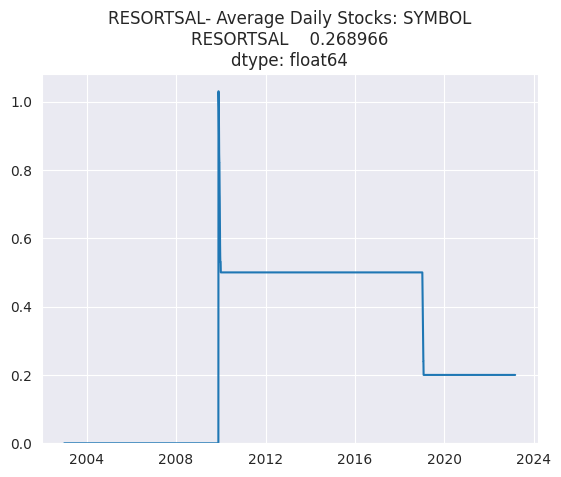

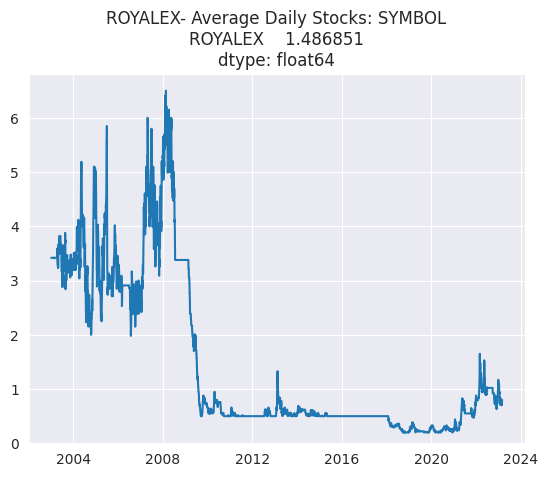

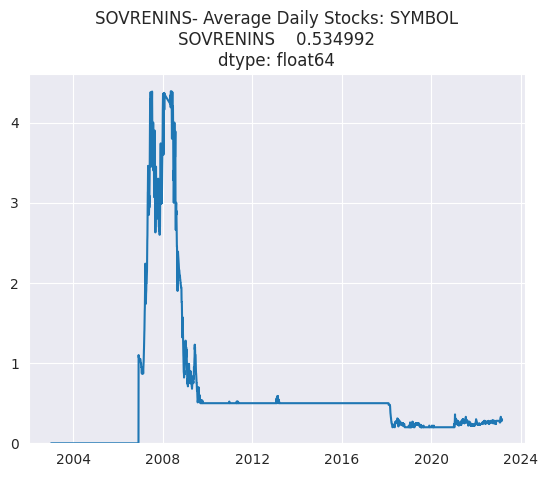

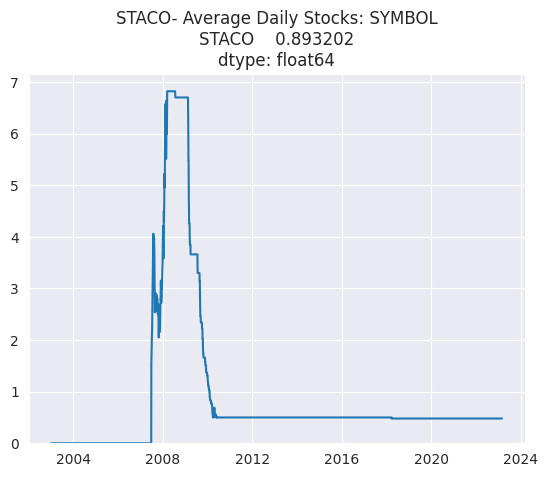

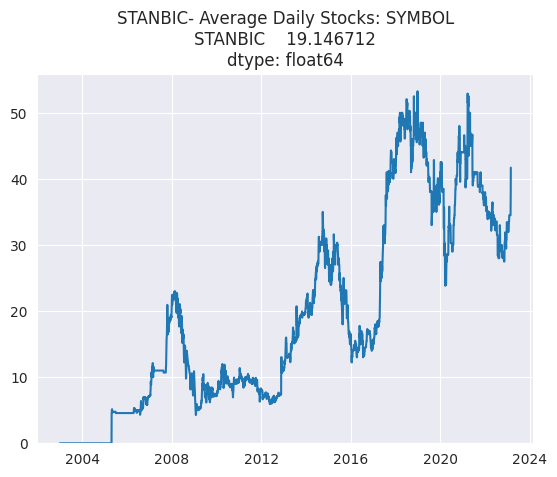

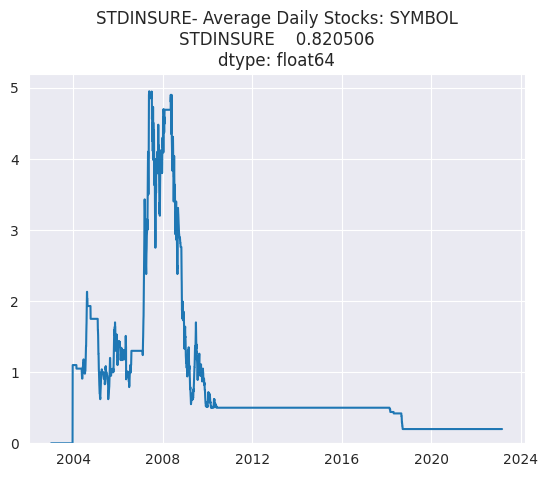

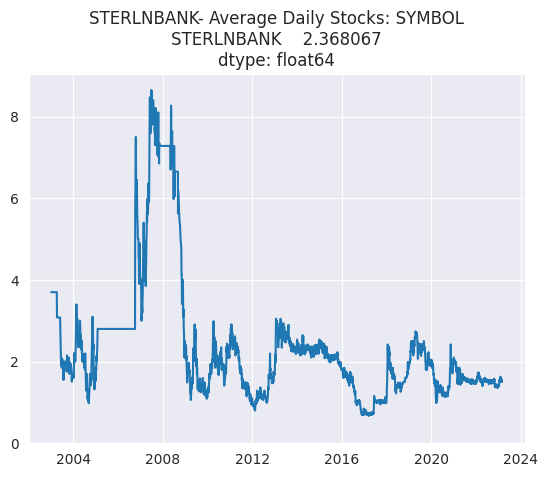

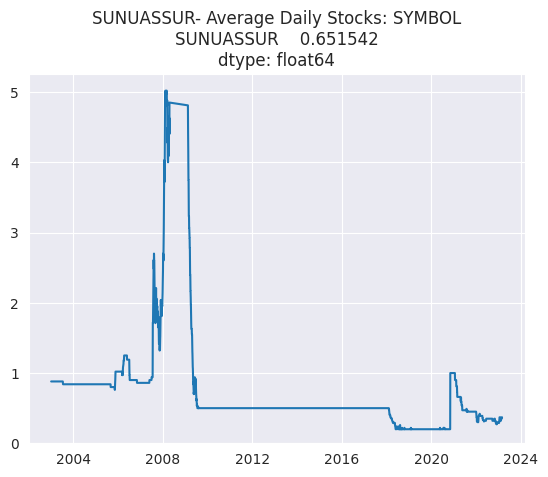

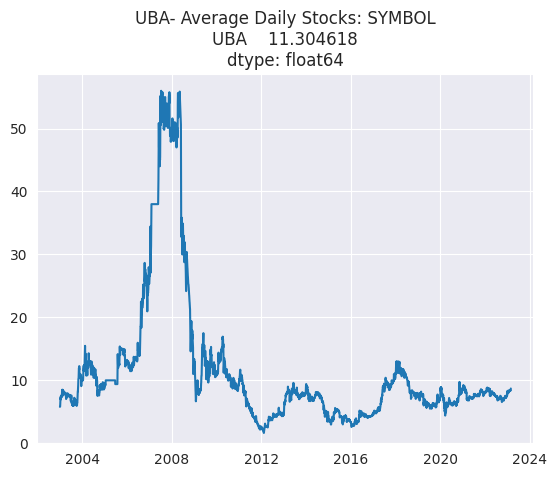

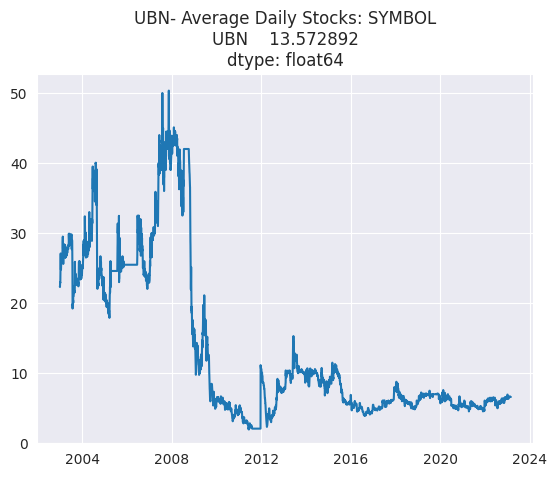

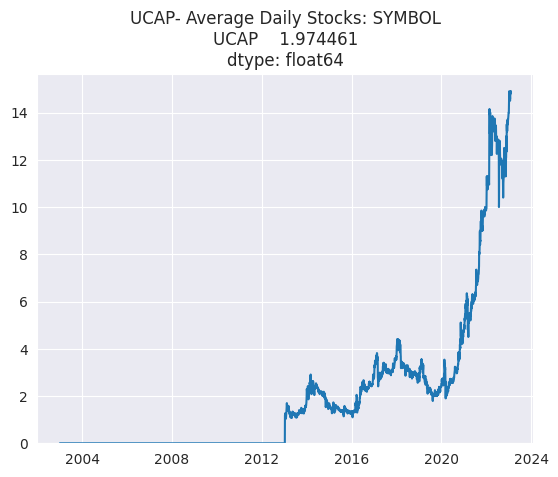

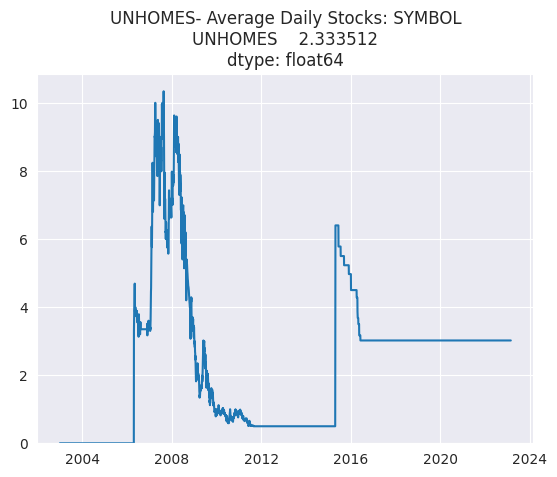

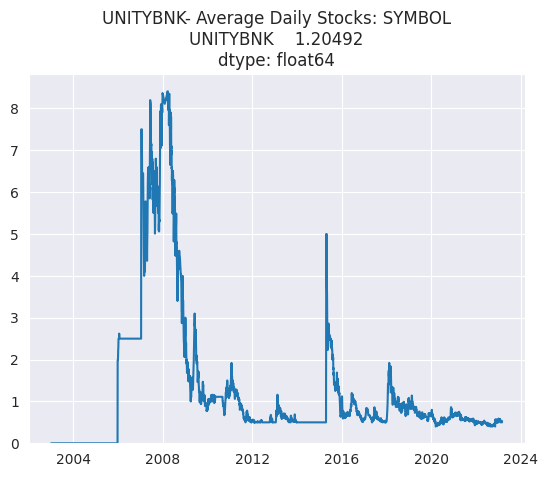

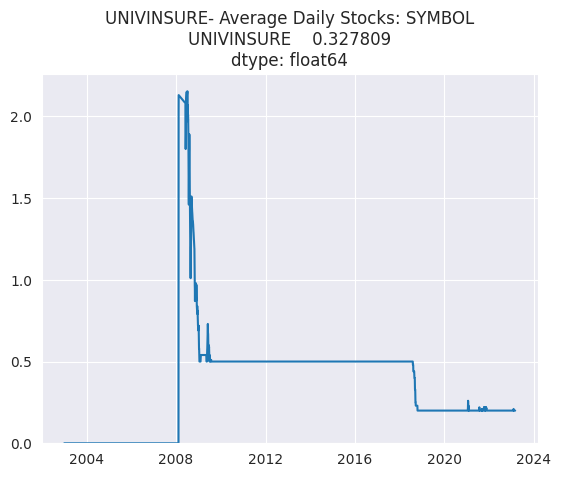

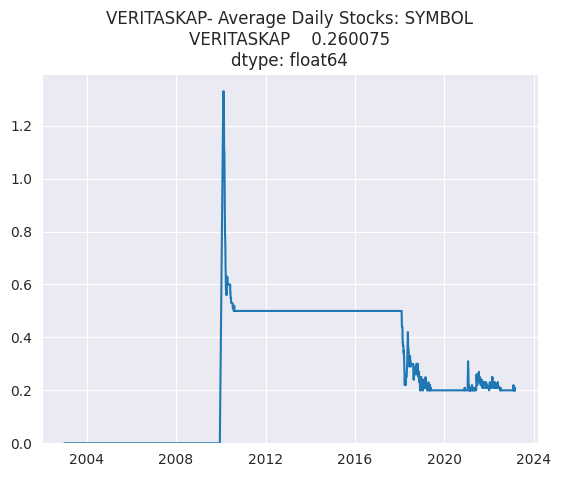

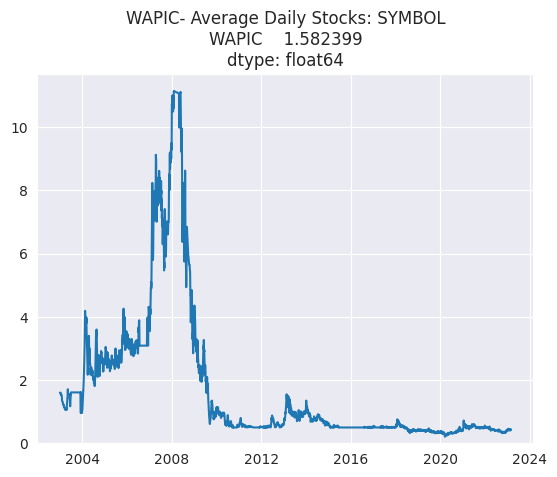

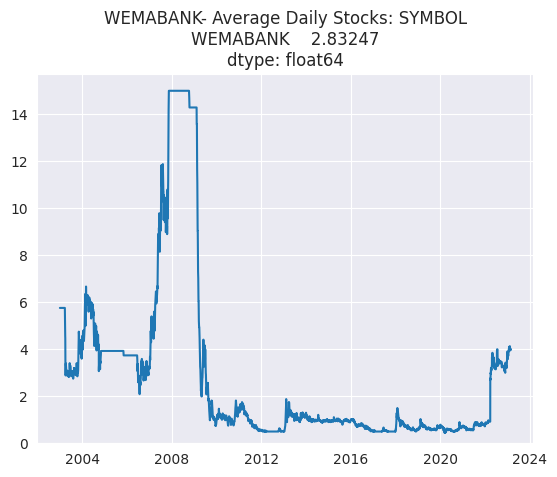

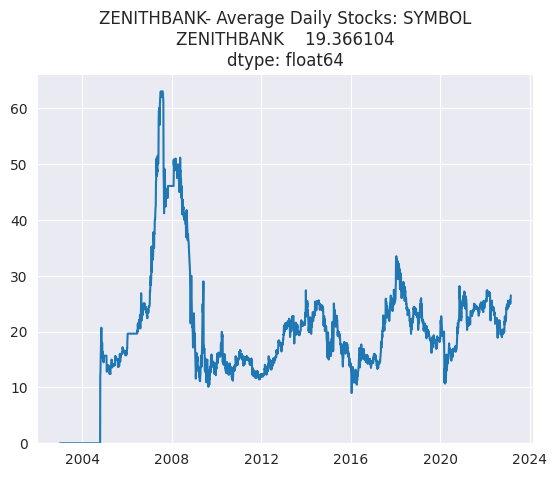

In [31]:
for i in range(len(prediction_df_financial_list)):
    plt.plot(prediction_df_financial_list[i])
    plt.title(prediction_df_financial_list[i].columns[0]+'- Average Daily Stocks: '+str(prediction_df_financial_list[i].mean()))
    plt.ylim(ymin=0)
    plt.show()

## sector-wise groupings (low/mid/high)

In [32]:
average_closeprices = financial_tsdata.apply(np.mean, axis=0).sort_values()
low, mid = np.percentile(financial_tsdata.apply(np.mean, axis=0).sort_values(), [25, 75])

In [33]:
low_vol_cols = list(average_closeprices[average_closeprices <= low].index)
mid_vol_cols = list(average_closeprices[(average_closeprices > low) & (average_closeprices < mid)].index)
high_vol_cols = list(average_closeprices[average_closeprices >= mid].index)

In [34]:
print(f'Low volume stocks are: {low_vol_cols}')
print(f'Middle volume stocks are: {mid_vol_cols}')
print(f'High volume stocks are: {high_vol_cols}')

Low volume stocks are: ['JAIZBANK', 'RESORTSAL', 'VERITASKAP', 'AFRINSURE', 'REGALINS', 'LIVINGTRUST', 'UNIVINSURE', 'GOLDINSURE', 'CHIPLC', 'ASOSAVINGS', 'SOVRENINS', 'GUINEAINS', 'INTENEGINS']
Middle volume stocks are: ['INFINITY', 'NPFMCRFBK', 'MBENEFIT', 'STDINSURE', 'SUNUASSUR', 'LASACO', 'STACO', 'LINKASSURE', 'ABBEYBDS', 'CORNERST', 'DEAPCAP', 'UNITYBNK', 'MANSARD', 'AIICO', 'NEM', 'ROYALEX', 'NGXGROUP', 'NIGERINS', 'WAPIC', 'AFRIPRUD', 'UCAP', 'PRESTIGE', 'UNHOMES']
High volume stocks are: ['STERLNBANK', 'FIDELITYBK', 'WEMABANK', 'FCMB', 'ACCESSCORP', 'UBA', 'UBN', 'FBNH', 'STANBIC', 'ZENITHBANK', 'GTCO', 'ETI', 'NESF']


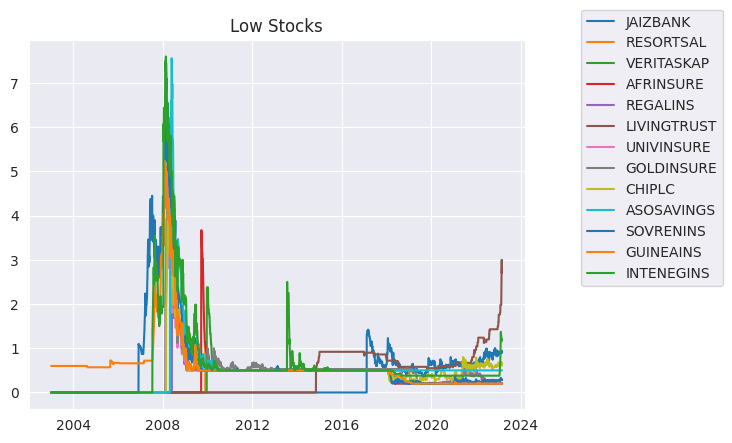

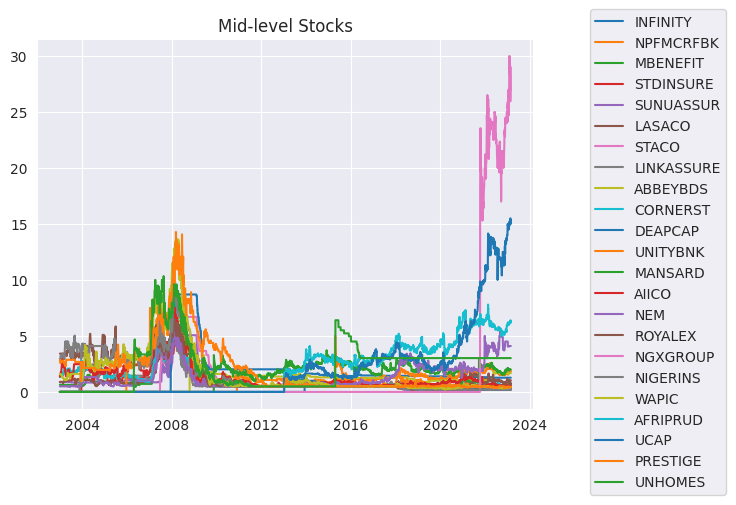

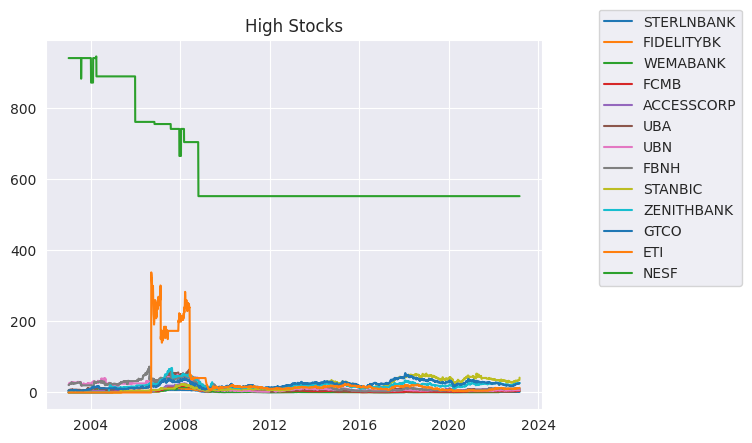

In [35]:
# financial_tsdata[low_vol_cols].plot.line()
plt.plot(financial_tsdata[low_vol_cols])
plt.legend(low_vol_cols, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.title("Low Stocks")
plt.show()

plt.plot(financial_tsdata[mid_vol_cols])
plt.legend(mid_vol_cols, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.title("Mid-level Stocks")
plt.show()

plt.plot(financial_tsdata[high_vol_cols])
plt.legend(high_vol_cols, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.title("High Stocks")
plt.show()

# MODEL BUILDING

## hyperparameter tuning

these parameters that can be tuned;

1. <b>`changepoint_prior_scale`</b>
2. <b>`seasonality_prior_scale`</b>
3. <b>`holidays_prior_scale`</b>
4. <b>`seasonality_mode`</b>
5. <b>`changepoint_range`</b>

In [36]:
changepoint_prior_scale_range = np.linspace(0.001, 0.5, num=5).tolist()
print(changepoint_prior_scale_range)

[0.001, 0.12575, 0.2505, 0.37525, 0.5]


In [37]:
seasonality_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()
holidays_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()

seasonality_mode_options = ['additive', 'multiplicative']
# changepoint_range_range = list(np.linspace(0.5, 0.95, num=5))

<hr>

<b>`NOTE:`</b><br> in order to determine the effective accuracy of the model, in prophet cross-validation, I have to cut off the data at various times within the dates (not including the `2003`), over a large timeframe, so as to normalize. This gives rise to the importance for <b>`cross-validation`</b> 


## cross validation (prophet pipeline)

finding the <b>`"best"`</b> parameters by testing over various periods of time with those parameters (cross-validation)

In [32]:
start_time = time.time()

dicts = {}

for feature in financial_tsdata.columns:
  
    stocksector_df = financial_tsdata[feature].copy().reset_index()
    stocksector_df.columns = ["ds", "y"]

    stocksector_df[["y"]] = stocksector_df[["y"]].apply(pd.to_numeric)
    stocksector_df["ds"] = pd.to_datetime(stocksector_df["ds"])
    
    param_grid = {  
        "changepoint_prior_scale": changepoint_prior_scale_range,
        "seasonality_prior_scale": seasonality_prior_scale_range }
        #'holidays_prior_scale': holidays_prior_scale_range,
        #'seasonality_mode': seasonality_mode_options,
        #'changepoint_range': changepoint_range_range,

    # to generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    mapes = [] 

    # cross validation to evaluate all parameters
    for params in all_params:
        m = Prophet(**params).fit(stocksector_df)  # fit model with given params
        df_cv = cross_validation(m, initial="365.25 days", period="365.25 days", horizon = "30 days") #took parallel out
        df_p = performance_metrics(df_cv, rolling_window=1)
        print(df_p)
        mapes.append(df_p["mape"].values[0])

    # Find the best parameters
    tuning_results = pd.DataFrame(all_params)
    tuning_results["mape"] = mapes
    
    print(feature)
    print(tuning_results.head())

    params_dict = dict(tuning_results.sort_values("mape").reset_index(drop=True).iloc[0])
    params_dict["column"] = feature 
    
    dicts[feature] = params_dict

print("--- %s seconds ---" % (time.time() - start_time))

21:27:39 - cmdstanpy - INFO - Chain [1] start processing
21:27:45 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/20 [00:00<?, ?it/s]21:27:46 - cmdstanpy - INFO - Chain [1] start processing
21:27:46 - cmdstanpy - INFO - Chain [1] done processing
  5%|▌         | 1/20 [00:00<00:09,  2.02it/s]21:27:47 - cmdstanpy - INFO - Chain [1] start processing
21:27:47 - cmdstanpy - INFO - Chain [1] done processing
 10%|█         | 2/20 [00:01<00:11,  1.52it/s]21:27:48 - cmdstanpy - INFO - Chain [1] start processing
21:27:48 - cmdstanpy - INFO - Chain [1] done processing
 15%|█▌        | 3/20 [00:02<00:15,  1.10it/s]21:27:49 - cmdstanpy - INFO - Chain [1] start processing
21:27:50 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 4/20 [00:04<00:20,  1.27s/it]21:27:51 - cmdstanpy - INFO - Chain [1] start processing
21:27:51 - cmdstanpy - INFO - Chain [1] done processing
21:27:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Opti

  horizon        mse      rmse       mae      mape     mdape     smape  \
0 30 days  39.332431  6.271557  4.150187  0.731365  0.604964  0.542277   

   coverage  
0      0.68  


21:29:46 - cmdstanpy - INFO - Chain [1] start processing
21:29:52 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/20 [00:00<?, ?it/s]21:29:53 - cmdstanpy - INFO - Chain [1] start processing
21:29:53 - cmdstanpy - INFO - Chain [1] done processing
  5%|▌         | 1/20 [00:00<00:06,  2.85it/s]21:29:53 - cmdstanpy - INFO - Chain [1] start processing
21:29:53 - cmdstanpy - INFO - Chain [1] done processing
 10%|█         | 2/20 [00:00<00:06,  2.61it/s]21:29:54 - cmdstanpy - INFO - Chain [1] start processing
21:29:54 - cmdstanpy - INFO - Chain [1] done processing
 15%|█▌        | 3/20 [00:01<00:07,  2.18it/s]21:29:54 - cmdstanpy - INFO - Chain [1] start processing
21:29:55 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 4/20 [00:02<00:10,  1.60it/s]21:29:55 - cmdstanpy - INFO - Chain [1] start processing
21:29:55 - cmdstanpy - INFO - Chain [1] done processing
21:29:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Opti

  horizon        mse      rmse      mae      mape     mdape     smape  \
0 30 days  40.248777  6.344192  4.24156  0.750967  0.653068  0.562433   

   coverage  
0     0.665  


21:31:31 - cmdstanpy - INFO - Chain [1] start processing
21:31:36 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/20 [00:00<?, ?it/s]21:31:37 - cmdstanpy - INFO - Chain [1] start processing
21:31:37 - cmdstanpy - INFO - Chain [1] done processing
  5%|▌         | 1/20 [00:00<00:10,  1.83it/s]21:31:38 - cmdstanpy - INFO - Chain [1] start processing
21:31:38 - cmdstanpy - INFO - Chain [1] done processing
 10%|█         | 2/20 [00:01<00:11,  1.62it/s]21:31:38 - cmdstanpy - INFO - Chain [1] start processing
21:31:39 - cmdstanpy - INFO - Chain [1] done processing
 15%|█▌        | 3/20 [00:01<00:11,  1.52it/s]21:31:39 - cmdstanpy - INFO - Chain [1] start processing
21:31:39 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 4/20 [00:02<00:11,  1.34it/s]21:31:40 - cmdstanpy - INFO - Chain [1] start processing
21:31:40 - cmdstanpy - INFO - Chain [1] done processing
21:31:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Opti

  horizon        mse      rmse       mae    mape     mdape     smape  coverage
0 30 days  39.137275  6.255979  4.144125  0.7356  0.656892  0.563799  0.681667


21:33:20 - cmdstanpy - INFO - Chain [1] start processing
21:33:24 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/20 [00:00<?, ?it/s]21:33:24 - cmdstanpy - INFO - Chain [1] start processing
21:33:25 - cmdstanpy - INFO - Chain [1] done processing
  5%|▌         | 1/20 [00:00<00:07,  2.39it/s]21:33:25 - cmdstanpy - INFO - Chain [1] start processing
21:33:25 - cmdstanpy - INFO - Chain [1] done processing
 10%|█         | 2/20 [00:00<00:09,  1.97it/s]21:33:26 - cmdstanpy - INFO - Chain [1] start processing
21:33:26 - cmdstanpy - INFO - Chain [1] done processing
 15%|█▌        | 3/20 [00:01<00:11,  1.47it/s]21:33:27 - cmdstanpy - INFO - Chain [1] start processing
21:33:27 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 4/20 [00:02<00:13,  1.19it/s]21:33:28 - cmdstanpy - INFO - Chain [1] start processing
21:33:28 - cmdstanpy - INFO - Chain [1] done processing
21:33:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Opti

  horizon        mse      rmse       mae      mape     mdape    smape  \
0 30 days  40.535278  6.366732  4.243273  0.749784  0.625029  0.56539   

   coverage  
0  0.658333  


21:35:07 - cmdstanpy - INFO - Chain [1] start processing
21:35:11 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/20 [00:00<?, ?it/s]21:35:12 - cmdstanpy - INFO - Chain [1] start processing
21:35:12 - cmdstanpy - INFO - Chain [1] done processing
  5%|▌         | 1/20 [00:00<00:08,  2.22it/s]21:35:13 - cmdstanpy - INFO - Chain [1] start processing
21:35:13 - cmdstanpy - INFO - Chain [1] done processing
 10%|█         | 2/20 [00:00<00:08,  2.02it/s]21:35:13 - cmdstanpy - INFO - Chain [1] start processing
21:35:14 - cmdstanpy - INFO - Chain [1] done processing
 15%|█▌        | 3/20 [00:01<00:10,  1.57it/s]21:35:14 - cmdstanpy - INFO - Chain [1] start processing
21:35:14 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 4/20 [00:02<00:11,  1.34it/s]21:35:15 - cmdstanpy - INFO - Chain [1] start processing
21:35:15 - cmdstanpy - INFO - Chain [1] done processing
21:35:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Opti

  horizon        mse      rmse       mae      mape     mdape     smape  \
0 30 days  39.911405  6.317547  4.195237  0.739326  0.652104  0.558775   

   coverage  
0  0.671667  


21:36:57 - cmdstanpy - INFO - Chain [1] start processing


KeyboardInterrupt: 

<b>`"df_p"`</b> gives the overall MAPE, but if you want to get more granular and calculate the daily differences using the mape metric, the code is below. This allows you to detect issues in predicting certain time periods, which are inherent issues in the data that you may or may not be able to fix. 

In [43]:
#how to call params_dict for a feature

dicts

NameError: name 'dicts' is not defined

## feature engineering by `holidays`

In [ ]:
#adding holiday data

holiday = pd.DataFrame([])

nigeria_holidays = holidays.NG()  # this is a dict
# the below is the same, but takes a string:
nigeria_holidays = holidays.country_holidays('NG')  # this is a dict


for date_, name in sorted(holidays.NG(years=[2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023]).items()):
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date_, 'holiday': "NG-Holidays", 'lower_window': -2, 'upper_window': 1}, index=[0])], ignore_index=True) 

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')
holiday.head()

## backtesting with tuned metrics
`latest month up-to-date mape`

In [ ]:
prediction_days = 30
forecast_start_date = max(financial_tsdata.index) - timedelta(predictions_days)

<b>Note:</b> check a documentation here (reference to repo)!

In [ ]:
# PROPHET MODEL

forecasted_tsdata = []

for feature in financial_tsdata.columns:

    # prophet formats
    df_financial_copy = financial_tsdata[feature].copy().reset_index()
    df_financial_copy.columns = ['ds', 'y']
    df_financial_copy[['y']] = df_financial_copy[['y']].apply(pd.to_numeric)
    df_financial_copy['ds'] = pd.to_datetime(df_financial_copy['ds'])
    
    df_financial_copy_train = df_financial_copy[df_financial_copy['ds'] < forecast_start_date]
    
    # search & get the right param_dict for this sector
    param_dict = dicts[feature]
    
    # model
    model = Prophet(changepoint_prior_scale = dicts[feature]['changepoint_prior_scale'],
                   seasonality_prior_scale = dicts[feature]['seasonality_prior_scale'],
                   holidays = holiday)
    
    model.fit(df_financial_copy_train)
    
    future = model.make_future_dataframe(periods=prediction_days)
    fcst_prophet_train = m.predict(future)
    
    filter = fcst_prophet_train['ds'] >= forecast_start_date
    predicted_financial_df = fcst_prophet_train[filter]['ds', 'yhat']
    predicted_financial_df = predicted_financial_df.merge(df_financial_copy)

    print(feature, mape(predicted_financial_df['y'], predicted_financial_df['yhat']))

# FINAL FORECASTING

## forecast pipeline!!!

In [ ]:
days_of_predictiion = 672
start_date_of_forecast = max(financial_tsdata.index)

In [ ]:
# using prophet model technique

forecasted_dataframe = []

for feature in financial_tsdata.columns: # plotting for first five: for feature in constructionrs_tsdata.columns[:5]:

    # formatting
    financial_tsdata_copy = financial_tsdata[feature].copy().reset_index()
    financial_tsdata_copy.columns = ['ds', 'y']
    financial_tsdata_copy[['y']] = financial_tsdata_copy[['y']].apply(pd.to_numeric)
    financial_tsdata_copy['ds'] = pd.to_datetime(financial_tsdata_copy['ds'])

    financial_tsdata_copy_train = financial_tsdata_copy[financial_tsdata_copy['ds'] < start_date_of_forecast]

    # search and get the rightparam_dicts for the sector
    param_dicts = dicts[feature]

    # model
    m = Prophet(changepoint_prior_scale = dicts[feature]['changepoint_prior_scale'],
                seasonality_prior_scale = dicts[feature]['seasonality_prior_scale'],
                holidays = holiday)

    m.fit(financial_copy_train)

    future_df = m.make_future_dataframe(periods = days_of_prediction)
    forecast_prophet_train = m.predict(future_df)
    
    fig1 = m.plot(forecast_prophet_train)
    fig2 = m.plot_components(forecast_prophet_train)

    forecasted_df = forecast_prophet_train[forecast_prophet_train['ds'] >= start_date_of_forecast]
    forecasted_dataframe.append(forecasted_df)

## forecasting visualization
2023 - March to December
2024 - January to December (leap year)

## Conclusions
<b>`...........................................................................................................`</b>